In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing.image import load_img
import cv2
import gc
import random
import math
from keras import backend as K
from sklearn.model_selection import train_test_split


from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.utils import plot_model
import numpy as np
import pickle

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D,UpSampling2D,Input,LeakyReLU,Activation, add, Concatenate,Lambda
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.data import AUTOTUNE
import tensorflow as tf
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
K.clear_session()

In [18]:
import os
def load_imgs(how_many):
    """
        returns images in range of 'how_many'
    """
    path = '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/'
    #path ='/kaggle/input/stl10/train_images/'
    imgs_path = os.listdir(path)
    imgs = []
    
    for i,img in enumerate(imgs_path):
        if(i >= how_many):
            return imgs
        imgs.append(load_img(path+img))
    return imgs  

In [3]:
def to_np_array(images):
    new_images = []
    for image in images:
        new_images.append(np.array(image))
    return (np.array(new_images)/255.0)

In [4]:
def get_resized_images(images,size):
    """
        returns 3 np.arrays of the resized images
        the sizes are 72x72, 128x128, 288x288
    """
    imgs = []
    
    for img in images:
        img = img.resize((size,size))
        imgs.append(img)
        
    return to_np_array(imgs)

In [19]:
# loading only the first 100 pictures
imgs = load_imgs(100)

# getting the images in 72X72, 144X144, 288X288 pixels
imgs_72 = get_resized_images(imgs,72)
imgs_128 = get_resized_images(imgs,128)
imgs_288 = get_resized_images(imgs,288)

# printing the images shape
imgs_72.shape,imgs_128.shape,imgs_288.shape

((100, 72, 72, 3), (100, 128, 128, 3), (100, 288, 288, 3))

In [20]:
def plot_imgs(rows,cols,imgs,titles):
    """
        plots images side by side
    """
    fix,ax = plt.subplots(rows,cols,figsize=(20,12))
    for i in range(len(imgs)):
        if len(imgs)//cols > 1:
            ax[i//cols,i%cols].set_title(titles[i])
            ax[i//cols,i%cols].imshow(imgs[i])
        else:
            ax[i].set_title(titles[i])
            ax[i].imshow(imgs[i])

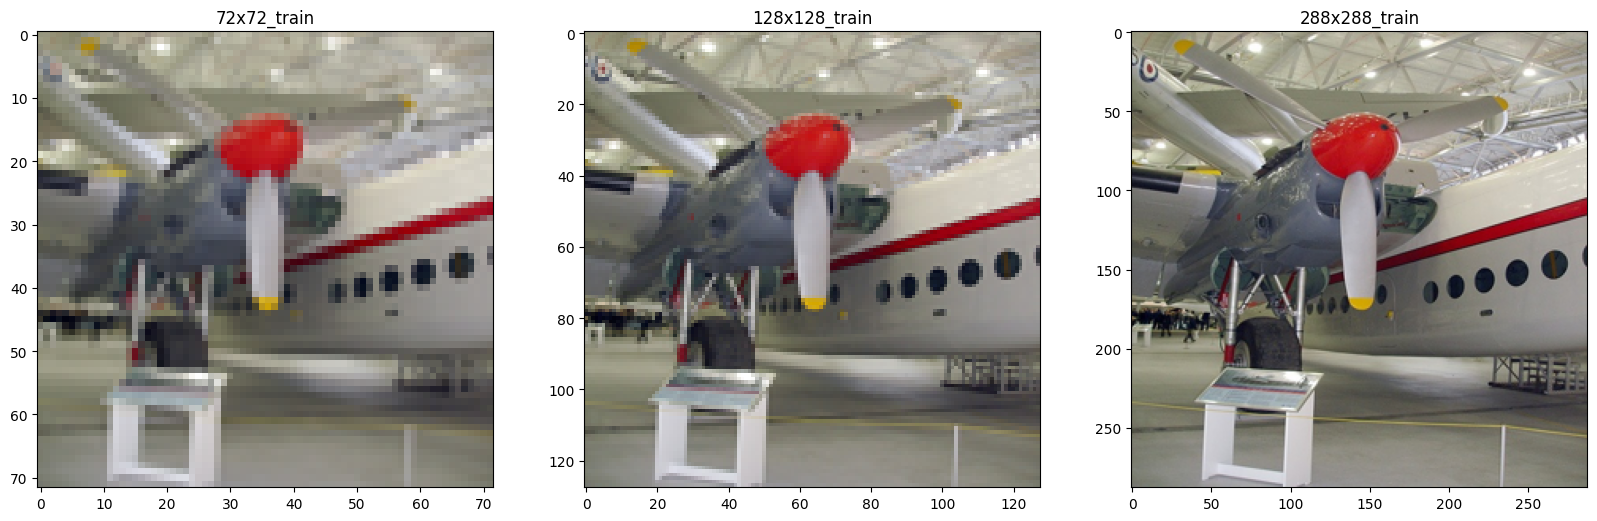

In [8]:
titles_3 = ["72x72_train","128x128_train","288x288_train"]
curr_img = 5
plot_imgs(1,3,[imgs_72[curr_img],imgs_128[curr_img],imgs_288[curr_img]],titles_3)

In [9]:
def get_gen_one(lower,upper,size,epochs=1):
    for e in range(epochs):
        path = '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/'
        imgs_path = os.listdir(path)
        print(imgs_path)
        for i,img in enumerate(imgs_path):
            if(i in range(lower,upper)):
                curr_img = load_img(path+img)
                curr_img = curr_img.resize((size,size))
                curr_img = np.array(curr_img)/255.0
                yield np.expand_dims(curr_img,axis=0)

In [ ]:

path = '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/'
#imgs_path = os.listdir(path)


In [21]:
def addNoise(x_train1):
    x_train_noisy_lst =[]
    x_val_noisy_lst = []
    x_test_noisy_lst = []
    mean = 0
    sigma = 25
    # Generate Gaussian noise
    #gauss_noise = np.random.normal(mean, sigma, (128,128,3)).astype('uint8')
    #print(gauss_noise.shape)
    #cv2.randn(gauss_noise,128,20)
    #gauss_noise=(gauss_noise*0.5).astype(np.uint8)
  # Add Gaussian noise to the input images
    noise_factor = 0.5
    x_train_noisy = x_train1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train1.shape)
    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    
    '''for i in range (len(x_train1)):
        time.sleep(0.01)
        #print(x_train1[i].shape)
        #gauss_noise = np.random.normal(mean, sigma, x_train1[i].shape).astype('uint8')
        #x_train_noisy=cv2.add(x_train1[i],gauss_noise)
        
        x_train_noisy = x_train1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train1.shape)
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        x_train_noisy_lst.append(x_train_noisy)
        #x_train_noisy_lst = np.array(x_train_noisy_lst)
    for j in range(len(x_val1)):
        time.sleep(0.01)
        #gauss_noise = np.random.normal(mean, sigma, x_val1[i].shape).astype('uint8')
        #x_val_noisy=cv2.add(x_val1[j],gauss_noise)
        x_val_noisy = x_val1[j] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val1[j].shape)
        x_val_noisy = np.clip(x_val_noisy, 0., 1.)
        x_val_noisy_lst.append(x_val_noisy)
        x_val_noisy_lst = np.array(x_val_noisy_lst)
    for k in range(len(x_test1)) : 
        time.sleep(0.01)
        #gauss_noise = np.random.normal(mean, sigma, x_test1[i].shape).astype('uint8')
        #x_test_noisy=cv2.add(x_test1[k],gauss_noise)
        x_test_noisy = x_test1 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test1[k].shape)
        x_test_noisy = np.clip(x_test_noisy, 0., 1.)
        x_test_noisy_lst.append(x_test_noisy)
        x_test_noisy_lst = np. array(x_test_noisy_lst)
    #x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    #x_val_noisy = np.clip(x_val_noisy, 0., 1.)
    #x_test_noisy = np.clip(x_test_noisy, 0., 1.)'''

    return x_train_noisy

In [22]:
import pandas as pd
train_file=""
val_file=""
df_train_pre = pd.DataFrame()
df_val_pre = pd.DataFrame()
df_train = pd.DataFrame()

label_path = '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/ImageSets/Main'
files=os.listdir(os.path.join(label_path))
for file in files:

    if file.endswith("diningtable_train.txt") or file.endswith("dog_train.txt") or file.endswith("sofa_train.txt") or file.endswith("sheep_train.txt") or file.endswith("horse_train.txt") :
        df1 = pd.DataFrame()
        train_file = file
        col_names = ["image_index", "col2", "col3",]
        df1 = pd.read_csv(label_path + os.sep + train_file ,header=None,encoding='utf-8',names=col_names,sep=" ")

        df1['label'] = train_file
        df1=df1[df1["col3"]== 1]
        df_train_pre = pd.concat([df_train_pre, df1], axis=0)
        df_train=df_train_pre[df_train_pre["col3"]== 1]
        
        data =df_train['label'].str.split('_',expand=True)
        df_train['label']= data[0]
        df_train["image_index"] = df_train["image_index"].astype(str)
        df_train["image_index"] = df_train["image_index"].str.pad(width=6, fillchar='0')
        #df_train["image_index"] = df_train["image_index"].apply(lambda x: '{0:0>3}'.format(x))
        print(file)
        #print("Train_ Report present")

    elif file.endswith("_val.txt") :
        df2 = pd.DataFrame()
    
        val_file=file
        col_names = ["image_index", "col2", "col3",]
        df2=pd.read_csv(label_path + os.sep + val_file ,header=None ,encoding='utf-8',names=col_names,sep=" ")
        df2['label'] = val_file
        df2=df2[df2["col3"]== 1]
        df_val_pre = pd.concat([df_val_pre, df2], axis=0)
        df_val=df_train_pre[df_train_pre["col3"]== 1]
        data =df_val['label'].str.split('_',expand=True)
        df_val['label']= data[0]
        df_val["image_index"] = df_val["image_index"].astype(str)
        df_val["image_index"] = df_val["image_index"].str.pad(width=6, fillchar='0')
        print(file)
        


df_train.drop(["col2", "col3"], axis='columns', inplace=True)
sufix = '.jpg'
df_train["image_index"] = df_train["image_index"].astype(str).apply(lambda x:  x + sufix)

df_train.sort_values(['image_index'], ascending=[True],inplace=True,ignore_index=True)
df_train.drop_duplicates(subset ="image_index",keep ='first', inplace = True)

df_val.drop(["col2", "col3"], axis='columns', inplace=True)
df_val["image_index"] = df_val["image_index"].astype(str) + '.jpg'
df_val.sort_values(['image_index'], ascending=[True],inplace=True,ignore_index=True)
df_val.drop_duplicates(subset ="image_index",keep ='first', inplace = True)
print(df_train.isnull().sum())
print(df_train.info())
print(df_train.shape)
print(df_val.shape)
#check = pd.merge (df_train,df_val,on='image_index',how='left',indicator='j').query('j =="left_only"')

diningtable_train.txt
sofa_train.txt
sheep_train.txt
horse_train.txt
chair_val.txt
bird_val.txt
horse_val.txt
train_val.txt
diningtable_val.txt
cat_val.txt
dog_train.txt
cow_val.txt
bus_val.txt
person_val.txt
bottle_val.txt
tvmonitor_val.txt
aeroplane_val.txt
boat_val.txt
motorbike_val.txt
pottedplant_val.txt
bicycle_val.txt
sofa_val.txt
dog_val.txt
car_val.txt
sheep_val.txt
image_index    0
label          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 575 entries, 0 to 597
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_index  575 non-null    object
 1   label        575 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB
None
(575, 2)
(575, 2)


In [ ]:
df_train.shape


In [23]:
def find_lable(path1,label_name_list):
    #file_list = os.listdir(path1)
    label_list =[]
    dict_label = {'person':1,'bird':2,'cat':3, 'cow':4,'dog':5,'horse':6,'sheep':7,
                    'aeroplane':8, 'bicycle':9,'boat':10, 'bus':11,'car':12,'chair':12,
                    'motorbike':13, 'train':14,'bottle':15,'chair':16,
                    'diningtable':17,
                    'table':18,
                    'pottedplant':19,
                    'plant':20,
                    'sofa':21,
                    'tvmonitor':22 }

    #dict_label1 = {'A':1,'not_A':2 }

    for name in label_name_list :

        #if len(label_name_list)!= 0 :
            for k,v in dict_label.items():
                #print("Label",name)
                if  name == k :
                    #print('value ',v)
                    label_list.append(v)

    label_list = np.array(label_list)
    print('label_list',len(label_list))
    return label_list

In [24]:
def data_extraction(path1,df_1,n,m):


    x_t =[]
    y_t1 =[]
    img_x = []
    img_y = []

    image_names =  df_1['image_index'] .tolist()
    images = []


    for image_name in image_names:
      image_path = os.path.join(path1, image_name)
      if os.path.exists(image_path):
            #image = Image.open(image_path)
            image =(cv2.resize(cv2.imread(image_path),(n,m)))
            #time.sleep(0.001)
            images.append(image)


    # convert the images in to array
    # Normalize pixel values to be between 0 and 1
    x_t = np.array(images)/255
    #print(x_t)
    label_name =  df_1['label'] .tolist()
    y_label = find_lable(path1,label_name)

    #df = pd.read_csv('/content/gdrive/MyDrive/charts/' + 'train_val.csv')
    #df['label']=""
    #print(df['type'].unique())


    #print("image_list", label_name)
    print(len(label_name))



    return x_t , y_label

Data extraction done from '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/' 

In [127]:
path = '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/'
x_train , y_train = data_extraction(path,df_train,128,128)
#x_val , y_val = data_extraction(path,df_val,72,72)

ValueError: not enough values to unpack (expected 2, got 0)

In [118]:
#structural_similarity index
from statistics import mean
def ssim_loss_image(im1_lst, im2_lst,size ):
    ssim_lst = []
    for im1 , im2 in zip(im1_lst, im2_lst):
        # Add an outer batch for each image.
        im1 = tf.cast(im1, tf.float32)
        im2 = tf.cast(im2, tf.float32)
        # Compute SSIM over tf.uint8 Tensors.
        ssim = tf.image.ssim(im1, im2, max_val= 1.0,filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
        result = ssim .numpy()
        ssim_lst.append(result)
    return mean(ssim_lst)

In [125]:


#X = np.concatenate([x_train, x_val])
X = x_train.copy()


#80-10-10 Split
train , val ,test = 0.8 ,0.1 ,0.1

# Split into training, validation, and test sets
x_train_val_90_1, x_test_10_1 = train_test_split( X, test_size=test, random_state=42)

x_train_80_1, x_val_10_1 = train_test_split(x_train_val_90_1, test_size= val /(train+val), random_state=42)

x_train_noisy_1  = addNoise(x_train1 = x_train_80_1)
x_val_noisy_1  = addNoise(x_train1 = x_val_10_1)
x_test_noisy_1 = addNoise(x_train1 = x_test_10_1)
#---------------------------------------------------------------------------------------------------------------------
train , val ,test = 0.7 ,0.1 ,0.2

# Split into training, validation, and test sets
x_train_val_80_2, x_test_20_2 = train_test_split( X, test_size=test, random_state=42)

x_train_70_2, x_val_10_2 = train_test_split(x_train_val_80_2, test_size= val /(train+val), random_state=42)

x_train_noisy_2 = addNoise(x_train1 = x_train_70_2)
x_val_noisy_2 = addNoise(x_train1 = x_val_10_2)
x_test_noisy_2 = addNoise(x_train1 =  x_test_20_2)

8. Use any other metric of your choice (apart from MSE, MAE) to judge the
image quality.

In [117]:


from tensorflow.keras import backend as K

def root_mean_squared_log_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))

# Loss functtion 
# The structural similarity index measure (SSIM) is a method for predicting the perceived quality of digital television and cinematic pictures
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [29]:
class AutoEncoder():

    def __init__(self,input_dim,enc_filters,enc_strides,
                 filter_size,bottleneck,dec_filters,dec_strides,batch_norm=False):

        #AE Initialization
        self.input_dim=input_dim
        self.enc_filters=enc_filters
        self.enc_strides=enc_strides
        self.filter_size=filter_size
        self.latent_space=bottleneck
        self.num_layers=len(enc_filters)
        self.batch_norm=batch_norm

        self.dec_filters=dec_filters
        self.dec_strides=dec_strides

        self._build()

    def _build(self):


        #Encoder Stack
        encoder_input=Input(shape=self.input_dim,name='encoder_input')
        x=encoder_input


        for lyr in range(0,self.num_layers):

            conv_layer=Conv2D(filters=self.enc_filters[lyr],kernel_size=self.filter_size[lyr],
                              strides=self.enc_strides[lyr],name='encoder_conv'+str(lyr),padding ='same')
            x=conv_layer(x)
            x=LeakyReLU()(x)

            if self.batch_norm==True:
                x=BatchNormalization()(x)

        shape_before_flattening=K.int_shape(x)[1:]
        x=Flatten()(x)

        encoder_output= Dense(self.latent_space, name='encoder_output')(x)
        #encoder_output=Activation('sigmoid')(x)
        self.encoder=Model(encoder_input, encoder_output)

        #Decoder
        decoder_input=Input(shape=self.latent_space,name='decoder_input')
        x=Dense(np.prod(shape_before_flattening))(decoder_input)
        x=Reshape(shape_before_flattening)(x)
        print(x.shape)
        for lyr in range(4):

            conv_t_layer=Conv2DTranspose(filters=self.dec_filters[lyr],kernel_size=self.filter_size[lyr],
                              strides=self.dec_strides[lyr],name='decoder_conv_t'+str(lyr),padding ='same')
            x=conv_t_layer(x)

            if lyr<self.num_layers-1:

                x=LeakyReLU()(x)

                if self.batch_norm==True:
                    x = BatchNormalization()(x)
            else:
                x=Activation('sigmoid')(x)

        decoder_output=x
        self.decoder=Model(decoder_input,decoder_output)

        #Joining Encoder and the decoder
        model_input = encoder_input
        model_output = self.decoder(encoder_output)
        self.model = Model(model_input, model_output)
        
    def load_weights(self,path_name):
        self.model.load_weights(path_name)
        

    def save_model(self):
        #save the model class parameters

        with open(os.path.join(os.getcwd(), 'model/params.pkl'), 'wb') as f:
            pickle.dump([self.input_dim,
                         self.enc_filters,
                         self.enc_strides,
                         self.filter_size,
                         self.latent_space,
                         self.dec_filters,
                         self.dec_strides,
                         self.batch_norm],f)

    
    def compile_mse(self,initial_lr):
        self.initial_lr=initial_lr
        self.model.compile(optimizer=Adam(learning_rate=self.initial_lr),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error','MeanSquaredLogarithmicError',ssim_loss])

    

    def train(self,x_train_noisy,x_train,batch_size,shuffle,epochs,callbacks_list,x_val_noisy,x_val):

        history = self.model.fit(x=x_train_noisy,y=x_train,batch_size=batch_size,
                       shuffle=shuffle,epochs=epochs,callbacks=callbacks_list,validation_data=(x_val_noisy, x_val))
        return history
        #autoencoder.fit(x_train_noisy_flat, x_train_flat, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test_noisy_flat, x_test_flat))

Here we have taken Step decay Learning rate 

In [30]:
def step_decay(epoch):
    initial_lrate=0.001
    step_size=10
    decay_factor=0.5
    new_lr=initial_lrate * (decay_factor ** np.floor(epoch/step_size))
    print(new_lr,epoch)
    return new_lr

In [21]:
# Autoencoder model
bottleneck= 256
ae=AutoEncoder(
    input_dim=(128,128,3),
    enc_filters=[32,16,8],
    enc_strides=[1,2,2],
    filter_size=[3,3,3,3],
    bottleneck = 256,
    dec_filters=[8,16,32,3],
    dec_strides=[2,2,1,1],
    batch_norm=True
    )

(None, 32, 32, 8)


In [ ]:
ae.encoder.summary()

In [ ]:
ae.decoder.summary()

**3. a. 256 (run using both the splits in 2, and choose the best one for the further set of experiments)** 

we have introduce two error 1 . SSIM  and 2 . mean_squared_logarithmic_error 

In [ ]:
plot_model(ae.model, 'autoencoder_no_compress.png', show_shapes=True)

"# Train the autoencoder  a. Use 80-10-10, train-val-test split"

In [31]:
# Autoencoder model
bottleneck = 256
ae1=AutoEncoder(
  input_dim=(128,128,3),
  enc_filters=[32,16,8],
  enc_strides=[1,2,2],
  filter_size=[3,3,3,3],
  bottleneck = bottleneck,
  dec_filters=[8,16,32,3],
  dec_strides=[2,2,1,1],
  batch_norm=True
  )
# Compile the model
learning_rate = 0.001
ae1.compile_mse(0.001)
checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights1/weights.h5'), save_weights_only = True, verbose=1)
lr_schedule=LearningRateScheduler(step_decay)
callbacks_list=[lr_schedule,checkpoint]

print('#'*50)
print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
# Train the autoencoder  a. Use 80-10-10, train-val-test split
output1 = ae1.train(x_train_noisy =x_train_noisy_1, x_train = x_train_80_1
, batch_size=16
, shuffle = True
, epochs = 30
, callbacks_list=callbacks_list , x_val_noisy = x_val_noisy_1 , x_val = x_val_10_1 )



(None, 32, 32, 8)
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.1989 - mean_squared_logarithmic_error: 0.0301 - ssim_loss: 0.3352
Epoch 1: saving model to /kaggle/working/weights1/weights.h5
29/29 [==============================] - 13s 101ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.1989 - mean_squared_logarithmic_error: 0.0301 - ssim_loss: 0.3352 - val_loss: 0.0687 - val_mean_squared_error: 0.0687 - val_mean_absolute_error: 0.2215 - val_mean_squared_logarithmic_error: 0.0370 - val_ssim_loss: 0.3883 - lr: 0.0010
0.001 1
Epoch 2/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0376 - mean_squared_error: 0.0376 - mean_absolute_error: 0.1513 - mean_squared_logarithmic_error: 0.0187 - ssim_loss: 0.4051
Epoch 2: saving model to /kaggle/working/w

"# Train the autoencoder  a. Use 70-10-20, train-val-test split"

In [100]:
#---------------------------------------------------------------------------------------------------------
ae2=AutoEncoder(
  input_dim=(128,128,3),
  enc_filters=[32,16,8],
  enc_strides=[1,2,2],
  filter_size=[3,3,3,3],
  bottleneck = bottleneck,
  dec_filters=[8,16,32,3],
  dec_strides=[2,2,1,1],
  batch_norm=True
  )
# Compile the model
learning_rate = 0.001
ae2.compile_mse(0.001)
checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights2/weights.h5'), save_weights_only = True, verbose=1)
lr_schedule=LearningRateScheduler(step_decay)
callbacks_list=[lr_schedule,checkpoint]

# Train the autoencoder b. Use 70-10-20, train-val-test split
print('#'*50)
print("# Train the autoencoder b. Use 70-10-20, train-val-test split")

output2 = ae2.train(x_train_noisy =x_train_noisy_2, x_train = x_train_70_2
  , batch_size=16
  , shuffle = True
  , epochs = 30
  , callbacks_list=callbacks_list , x_val_noisy = x_val_noisy_2 , x_val = x_val_10_2 )

(None, 32, 32, 8)
##################################################
# Train the autoencoder b. Use 70-10-20, train-val-test split
0.001 0
Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 0.0812 - mean_squared_error: 0.0812 - mean_absolute_error: 0.2255 - mean_squared_logarithmic_error: 0.0392 - ssim_loss: 0.3341
Epoch 1: saving model to /kaggle/working/weights2/weights.h5
26/26 [==============================] - 3s 65ms/step - loss: 0.0812 - mean_squared_error: 0.0812 - mean_absolute_error: 0.2255 - mean_squared_logarithmic_error: 0.0392 - ssim_loss: 0.3341 - val_loss: 0.0736 - val_mean_squared_error: 0.0736 - val_mean_absolute_error: 0.2309 - val_mean_squared_logarithmic_error: 0.0391 - val_ssim_loss: 0.3527 - lr: 0.0010
0.001 1
Epoch 2/30
25/26 [===========================>..] - ETA: 0s - loss: 0.0412 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1582 - mean_squared_logarithmic_error: 0.0203 - ssim_loss: 0.3991
Epoch 2: saving model to /kaggle/working/weig

 Plot ::::::"# Train the autoencoder  a. Use 80-10-10, train-val-test split"

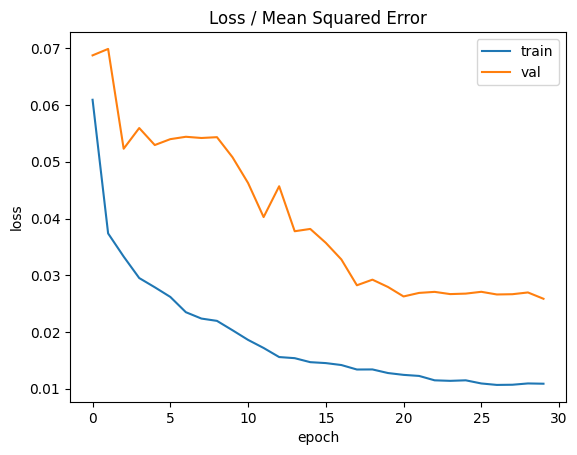

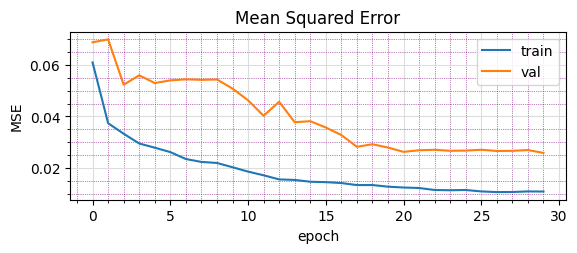

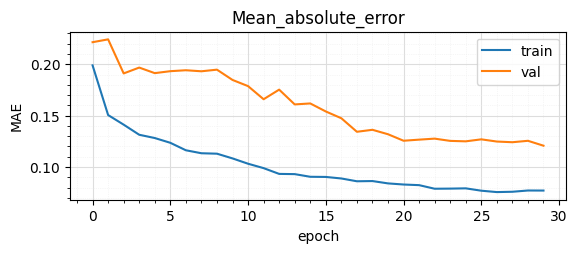

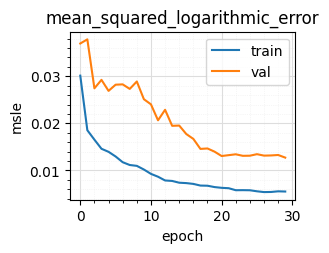

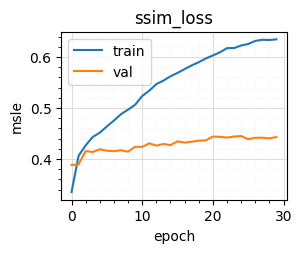

In [101]:
# plot loss during training
from matplotlib import pyplot
pyplot.title('Loss / Mean Squared Error')
#pyplot.grid(b=None, which='minor', axis='both')
pyplot.plot(output1.history['loss'], label='train')
pyplot.plot(output1.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
pyplot.legend()
pyplot.show()

# plot mse during training
ax3 = pyplot.subplot(211)
pyplot.title('Mean Squared Error')
pyplot.plot(output1.history['mean_squared_error'], label='train')
pyplot.plot(output1.history['val_mean_squared_error'], label='val')
plt.ylabel('MSE')
plt.xlabel('epoch')
ax3.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax3.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
ax3.minorticks_on()
pyplot.legend()
pyplot.show()
ax4 =pyplot.subplot(212)
pyplot.title('Mean_absolute_error')
pyplot.plot(output1.history['mean_absolute_error'], label='train')
pyplot.plot(output1.history['val_mean_absolute_error'], label='val')
plt.ylabel('MAE')
plt.xlabel('epoch')
ax4.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax4.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax4.minorticks_on()
pyplot.legend()
pyplot.show()

ax5 =pyplot.subplot(221)
pyplot.title('mean_squared_logarithmic_error')
pyplot.plot(output1.history['mean_squared_logarithmic_error'], label='train')
pyplot.plot(output1.history['val_mean_squared_logarithmic_error'], label='val')
plt.ylabel('msle')
plt.xlabel('epoch')
ax5.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax5.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax5.minorticks_on()
pyplot.legend()
pyplot.show()

ax6 =pyplot.subplot(222)
pyplot.title('ssim_loss')
pyplot.plot(output1.history['ssim_loss'], label='train')
pyplot.plot(output1.history['val_ssim_loss'], label='val')
plt.ylabel('msle')
plt.xlabel('epoch')
ax6.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax6.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax6.minorticks_on()
pyplot.legend()
pyplot.show()


# Train the autoencoder b. Use 70-10-20, train-val-test split** PLOT

Plot ::::::"# Train the autoencoder  a. Use 70-10-20, train-val-test split"

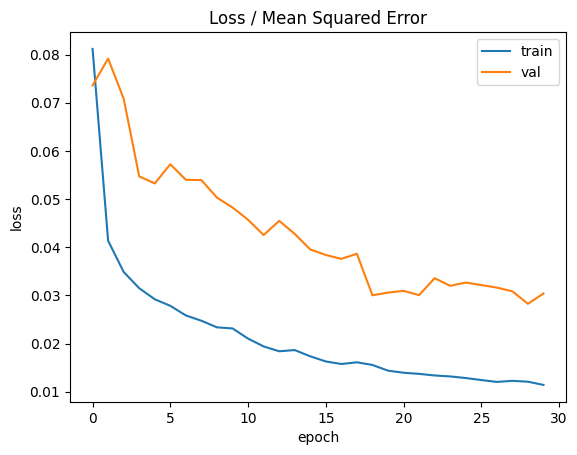

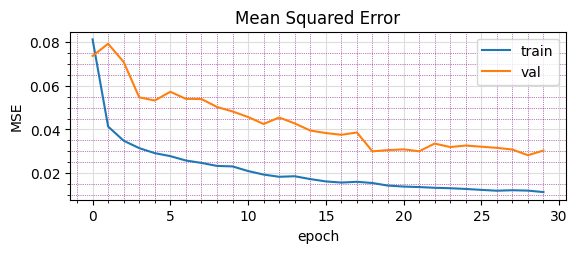

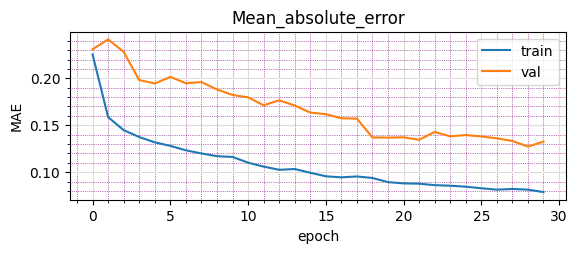

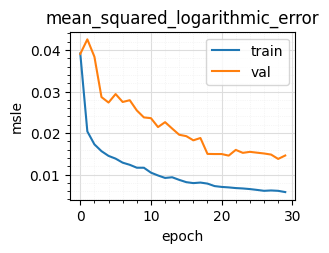

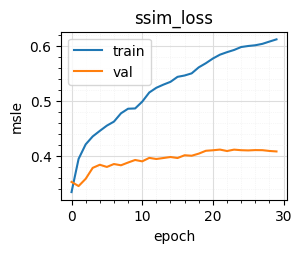

In [102]:
# plot loss during training
from matplotlib import pyplot

pyplot.title('Loss / Mean Squared Error')
pyplot.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
pyplot.plot(output2.history['loss'], label='train')
pyplot.plot(output2.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
pyplot.legend()
pyplot.show()

# plot mse during training
ax1 = pyplot.subplot(211)
pyplot.title('Mean Squared Error')
pyplot.plot(output2.history['mean_squared_error'], label='train')
pyplot.plot(output2.history['val_mean_squared_error'], label='val')
plt.ylabel('MSE')
plt.xlabel('epoch')
pyplot.legend()
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax1.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
ax1.minorticks_on()
pyplot.show()
ax2= pyplot.subplot(212)
pyplot.title('Mean_absolute_error')
pyplot.plot(output2.history['mean_absolute_error'], label='train')
pyplot.plot(output2.history['val_mean_absolute_error'], label='val')
plt.ylabel('MAE')
plt.xlabel('epoch')
ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax2.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
pyplot.legend()
ax2.minorticks_on()
pyplot.show()

ax5 =pyplot.subplot(221)
pyplot.title('mean_squared_logarithmic_error')
pyplot.plot(output2.history['mean_squared_logarithmic_error'], label='train')
pyplot.plot(output2.history['val_mean_squared_logarithmic_error'], label='val')
plt.ylabel('msle')
plt.xlabel('epoch')
ax5.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax5.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax5.minorticks_on()
pyplot.legend()
pyplot.show()

ax6 =pyplot.subplot(222)
pyplot.title('ssim_loss')
pyplot.plot(output2.history['ssim_loss'], label='train')
pyplot.plot(output2.history['val_ssim_loss'], label='val')
plt.ylabel('msle')
plt.xlabel('epoch')
ax6.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax6.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax6.minorticks_on()
pyplot.legend()
pyplot.show()

In [103]:
#structural_similarity index
from statistics import mean ,stdev
def ssim_loss(im1_lst, im2_lst,size ):
    ssim_lst = []
    for im1 , im2 in zip(im1_lst, im2_lst):
        # Add an outer batch for each image.
        im1 = tf.cast(im1, tf.float32)
        im2 = tf.cast(im2, tf.float32)
        # Compute SSIM over tf.uint8 Tensors.
        ssim = tf.image.ssim(im1, im2, max_val= 1.0,filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
        result = ssim .numpy()
        ssim_lst.append(result)
    return ssim_lst

**"# Train the autoencoder  a. Use 80-10-10, train-val-test split"  image comparison before and after gaussian noise addition** 
for bottlenech layer =256

2/2 [==============================] - 1s 617ms/step
ssim_average_value ==  0.225.
ssim_minimun_value ==  0.090.
ssim_maximum_value ==  0.467.
ssim_SD value reported == 0.074.
mean square error == 0.130.


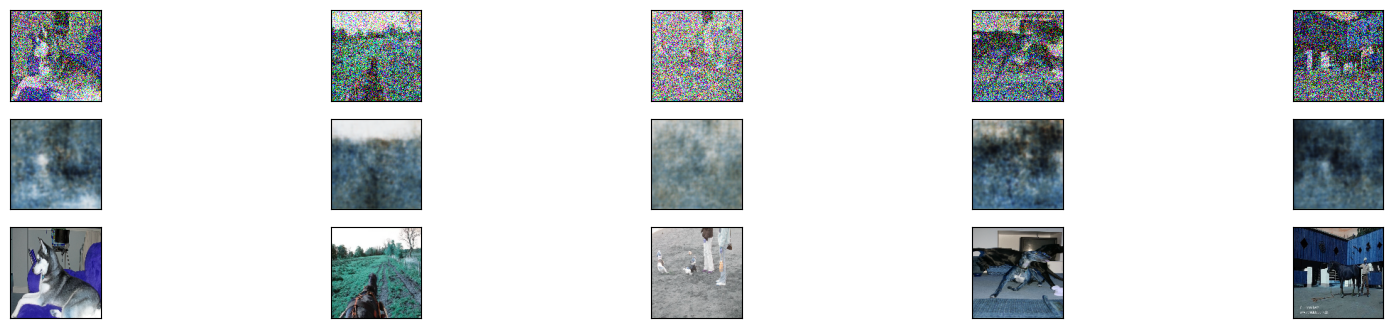

In [104]:

# Denoise images
# evaluation of test inamges
denoised_images = ae1.model.predict(x_test_noisy_1)

ssim_lst = ssim_loss(x_test_10_1, denoised_images,128)
ssim_average = mean(ssim_lst)
ssim_min = min(ssim_lst)
ssim_max = max(ssim_lst)
ssim_stdev = stdev(ssim_lst)
print(f'ssim_average_value ==  {ssim_average:.3f}.')
print(f'ssim_minimun_value ==  {ssim_min:.3f}.')
print(f'ssim_maximum_value ==  {ssim_max:.3f}.')

print(f'ssim_SD value reported == {ssim_stdev:.3f}.')

loss2 = tf.reduce_mean(tf.pow(x_test_noisy_1 - denoised_images, 2))
print(f'mean square error == {loss2.numpy():.3f}.')

# Optionally, you can visualize the denoised images
import matplotlib.pyplot as plt

n = 5  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display original images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_10_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    

plt.show()

**"# Train the autoencoder  a. Use 70-20-10, train-val-test split"  image comparison before and after gaussian noise addition** 
for bottlenech layer =256

4/4 [==============================] - 0s 18ms/step
ssim_average_value ==  0.242.
ssim_minimun_value ==  0.088.
ssim_maximum_value ==  0.486.
ssim_SD value reported == 0.075.
mean square error == 0.131.


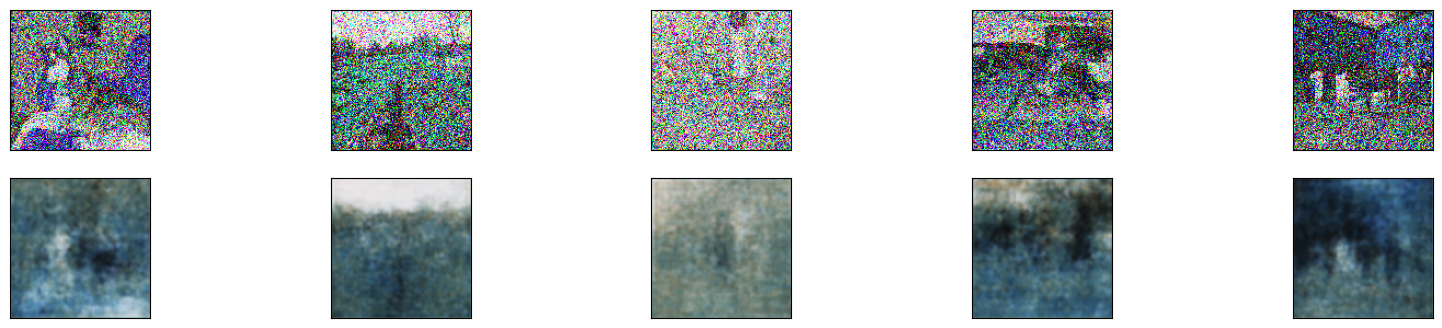

In [113]:
# Denoise images
# evaluation of test inamges
denoised_images_2 = ae2.model.predict(x_test_noisy_2)

ssim_lst = ssim_loss(x_test_20_2, denoised_images_2,128)
ssim_average = mean(ssim_lst)
ssim_min = min(ssim_lst)
ssim_max = max(ssim_lst)
ssim_stdev = stdev(ssim_lst)
print(f'ssim_average_value ==  {ssim_average:.3f}.')
print(f'ssim_minimun_value ==  {ssim_min:.3f}.')
print(f'ssim_maximum_value ==  {ssim_max:.3f}.')

print(f'ssim_SD value reported == {ssim_stdev:.3f}.')

loss2 = tf.reduce_mean(tf.pow(x_test_noisy_2 - denoised_images_2, 2))
print(f'mean square error == {loss2.numpy():.3f}.')

# Optionally, you can visualize the denoised images
import matplotlib.pyplot as plt

n = 5  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy_2[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_images_2[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display original images
    '''ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_20_2[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)'''
plt.show()

**80-10-10, train-val-test split::**
Epoch 30: saving model to /kaggle/working/weights1/weights.h5
29/29 [==============================] - 1s 27ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0767 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1269 - lr: 2.5000e-04

**70-10-20, train-val-test split::**
Epoch 30: saving model to /kaggle/working/weights2/weights.h5
26/26 [==============================] - 1s 22ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0871 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1467 - lr: 2.5000e-04


In [115]:
bottleneck_list = [128,64,32,16]

i = 0

ae_list = [str("conv_enc")+ str(bottleneck_list[i]) for i in range (len(bottleneck_list)) ] 
output_list = [str("output_conv_enc")+ str(bottleneck_list[i]) for i in range (len(bottleneck_list)) ]

bottleneck  = 128
(None, 32, 32, 8)
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_error: 0.1974 - mean_squared_logarithmic_error: 0.0291 - ssim_loss: 0.3354
Epoch 1: saving model to /kaggle/working/weights_conv_enc128/weights.h5
29/29 [==============================] - 3s 50ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1956 - mean_squared_logarithmic_error: 0.0287 - ssim_loss: 0.3398 - val_loss: 0.0809 - val_mean_squared_error: 0.0809 - val_mean_absolute_error: 0.2411 - val_mean_squared_logarithmic_error: 0.0431 - val_ssim_loss: 0.3758 - lr: 0.0010
0.001 1
Epoch 2/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1552 - mean_squared_logarithmic_error: 0.0194 - ssim_loss: 0.4054
Epoch 2: saving

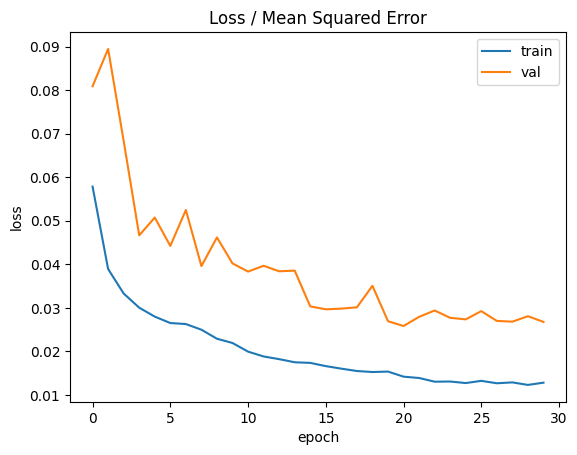

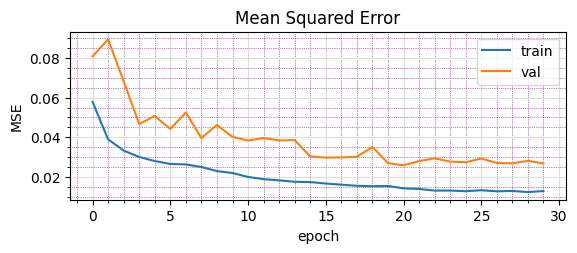

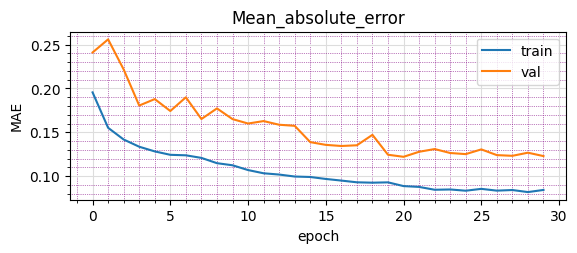

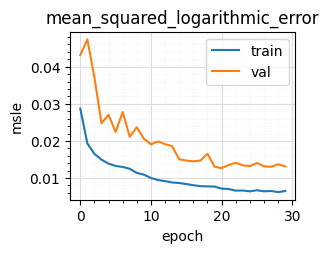

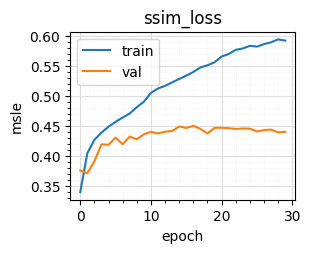

bottleneck  = 64
(None, 32, 32, 8)
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0731 - mean_squared_error: 0.0731 - mean_absolute_error: 0.2171 - mean_squared_logarithmic_error: 0.0363 - ssim_loss: 0.3314
Epoch 1: saving model to /kaggle/working/weights_conv_enc64/weights.h5
29/29 [==============================] - 3s 52ms/step - loss: 0.0717 - mean_squared_error: 0.0717 - mean_absolute_error: 0.2145 - mean_squared_logarithmic_error: 0.0356 - ssim_loss: 0.3336 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_mean_absolute_error: 0.2059 - val_mean_squared_logarithmic_error: 0.0321 - val_ssim_loss: 0.4047 - lr: 0.0010
0.001 1
Epoch 2/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0418 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1615 - mean_squared_logarithmic_error: 0.0207 - ssim_loss: 0.3979
Epoch 2: saving m

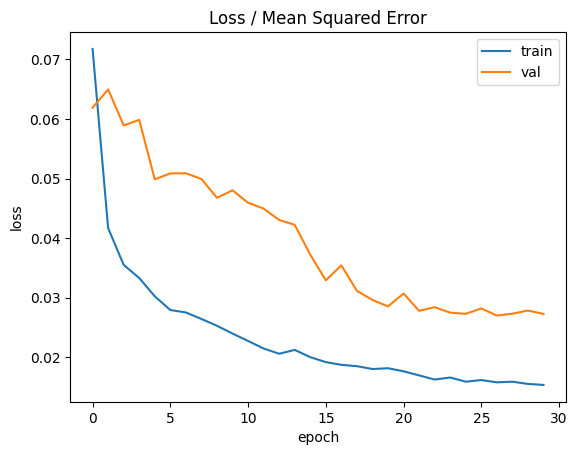

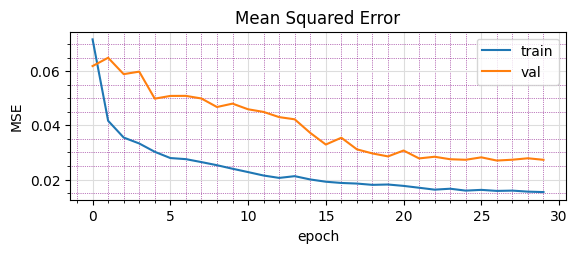

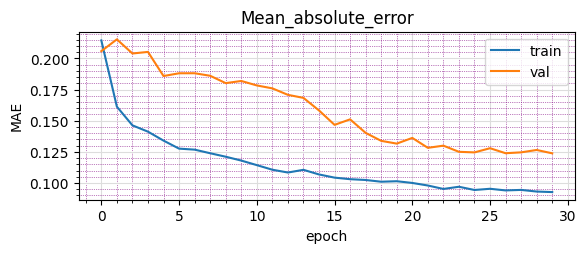

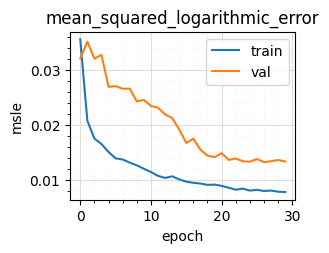

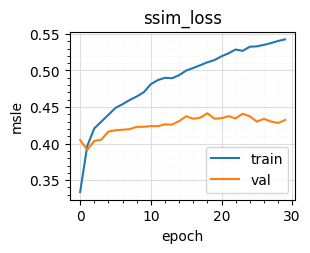

bottleneck  = 32
(None, 32, 32, 8)
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0636 - mean_squared_error: 0.0636 - mean_absolute_error: 0.2048 - mean_squared_logarithmic_error: 0.0314 - ssim_loss: 0.3343
Epoch 1: saving model to /kaggle/working/weights_conv_enc32/weights.h5
29/29 [==============================] - 3s 50ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.2029 - mean_squared_logarithmic_error: 0.0309 - ssim_loss: 0.3377 - val_loss: 0.0621 - val_mean_squared_error: 0.0621 - val_mean_absolute_error: 0.2087 - val_mean_squared_logarithmic_error: 0.0322 - val_ssim_loss: 0.4058 - lr: 0.0010
0.001 1
Epoch 2/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0425 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1631 - mean_squared_logarithmic_error: 0.0211 - ssim_loss: 0.4006
Epoch 2: saving m

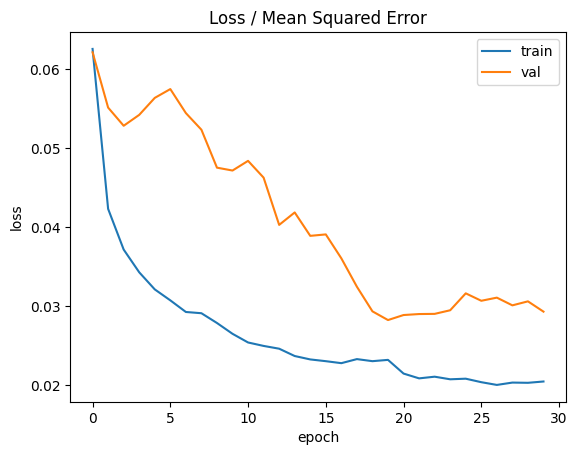

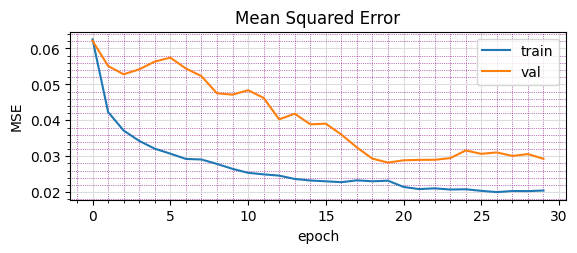

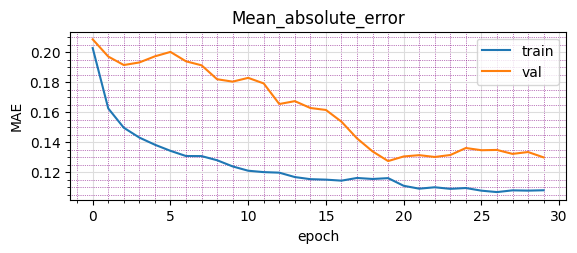

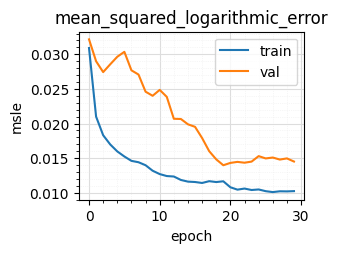

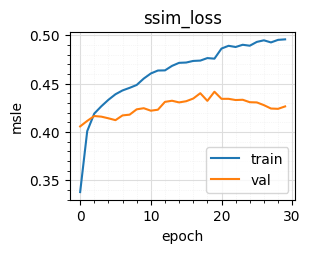

bottleneck  = 16
(None, 32, 32, 8)
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0759 - mean_squared_error: 0.0759 - mean_absolute_error: 0.2253 - mean_squared_logarithmic_error: 0.0375 - ssim_loss: 0.3182
Epoch 1: saving model to /kaggle/working/weights_conv_enc16/weights.h5
29/29 [==============================] - 3s 51ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - mean_absolute_error: 0.2226 - mean_squared_logarithmic_error: 0.0368 - ssim_loss: 0.3217 - val_loss: 0.0660 - val_mean_squared_error: 0.0660 - val_mean_absolute_error: 0.2115 - val_mean_squared_logarithmic_error: 0.0341 - val_ssim_loss: 0.4052 - lr: 0.0010
0.001 1
Epoch 2/30
27/29 [==========================>...] - ETA: 0s - loss: 0.0447 - mean_squared_error: 0.0447 - mean_absolute_error: 0.1683 - mean_squared_logarithmic_error: 0.0223 - ssim_loss: 0.3872
Epoch 2: saving m

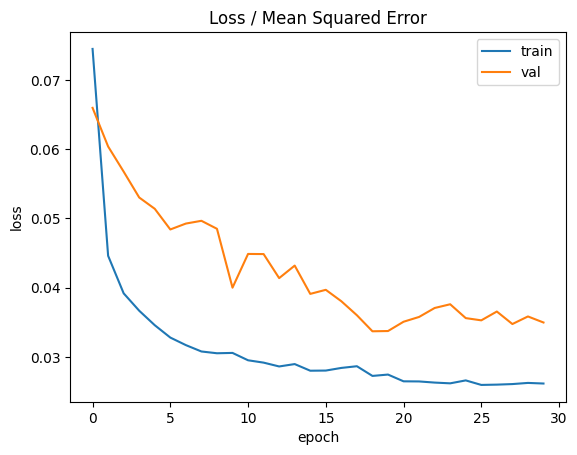

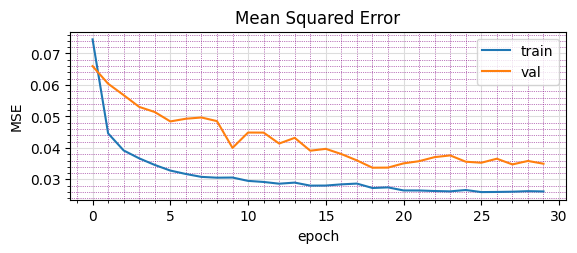

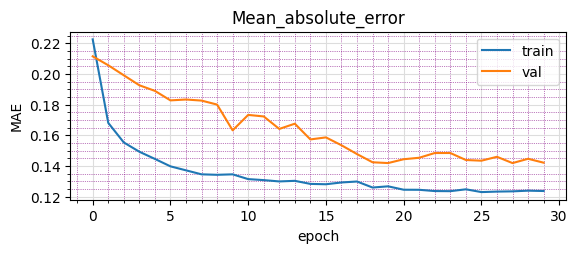

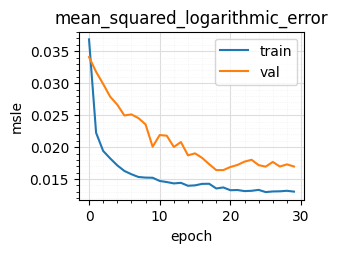

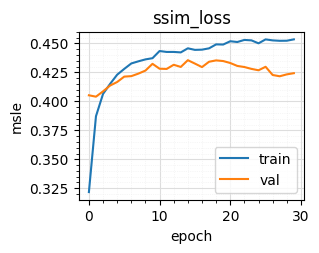

In [119]:
bottleneck_list = [128,64,32,16]

i = 0

ae_list = [str("conv_enc")+ str(i) for i in bottleneck_list ] 
output_list = [str("output_conv_enc")+ str(i) for i in bottleneck_list ]
# Autoencoder model
for bottleneck in bottleneck_list :
    print("bottleneck  =",bottleneck)
     
    ae_list[i]=AutoEncoder(
      input_dim=(128,128,3),
      enc_filters=[32,16,8],
      enc_strides=[1,2,2],
      filter_size=[3,3,3,3],
      bottleneck = bottleneck,
      dec_filters=[8,16,32,3],
      dec_strides=[2,2,1,1],
      batch_norm=True
      )
    # Compile the model
    learning_rate = 0.001
    ae_list[i].compile_mse(0.001)
    checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), "weights_conv_enc"+str(bottleneck)+"/weights.h5"), save_weights_only = True, verbose=1)
    lr_schedule=LearningRateScheduler(step_decay)
    callbacks_list=[lr_schedule,checkpoint]

    print('#'*50)
    print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
    # Train the autoencoder  a. Use 80-10-10, train-val-test split
    output_list[i] = ae_list[i].train(x_train_noisy =x_train_noisy_1, x_train = x_train_80_1
        , batch_size=16
        , shuffle = True
        , epochs = 30
        , callbacks_list=callbacks_list , x_val_noisy = x_val_noisy_1 , x_val = x_val_10_1 )
    
    # plot loss during training
    from matplotlib import pyplot

    pyplot.title('Loss / Mean Squared Error')
    pyplot.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    pyplot.plot(output_list[i].history['loss'], label='train')
    pyplot.plot(output_list[i].history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    pyplot.legend()
    pyplot.show()

    # plot mse during training
    ax1 = pyplot.subplot(211)
    pyplot.title('Mean Squared Error')
    pyplot.plot(output_list[i].history['mean_squared_error'], label='train')
    pyplot.plot(output_list[i].history['val_mean_squared_error'], label='val')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    pyplot.legend()
    ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax1.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
    ax1.minorticks_on()
    pyplot.show()
    ax2= pyplot.subplot(212)
    pyplot.title('Mean_absolute_error')
    pyplot.plot(output_list[i].history['mean_absolute_error'], label='train')
    pyplot.plot(output_list[i].history['val_mean_absolute_error'], label='val')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax2.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
    pyplot.legend()
    ax2.minorticks_on()
    pyplot.show()

    ax5 =pyplot.subplot(221)
    pyplot.title('mean_squared_logarithmic_error')
    pyplot.plot(output_list[i].history['mean_squared_logarithmic_error'], label='train')
    pyplot.plot(output_list[i].history['val_mean_squared_logarithmic_error'], label='val')
    plt.ylabel('msle')
    plt.xlabel('epoch')
    ax5.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax5.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax5.minorticks_on()
    pyplot.legend()
    pyplot.show()

    ax6 =pyplot.subplot(222)
    pyplot.title('ssim_loss')
    pyplot.plot(output_list[i].history['ssim_loss'], label='train')
    pyplot.plot(output_list[i].history['val_ssim_loss'], label='val')
    plt.ylabel('msle')
    plt.xlabel('epoch')
    ax6.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax6.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax6.minorticks_on()
    pyplot.legend()
    pyplot.show()

    i =+1
    

bottleneck  = 128

##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
Epoch 30: saving model to /kaggle/working/weights_conv_enc128/weights.h5
29/29 [==============================] - 1s 28ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0859 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1328 - lr: 2.5000e-04

bottleneck  = 64

##################################################
Epoch 30: saving model to /kaggle/working/weights_conv_enc64/weights.h5
29/29 [==============================] - 1s 27ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0965 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1303 - lr: 2.5000e-04

bottleneck  = 32

##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
Epoch 30: saving model to /kaggle/working/weights_conv_enc32/weights.h5
29/29 [==============================] - 1s 27ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1072 - val_loss: 0.0362 - val_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.1447 - lr: 2.5000e-04

bottleneck  = 16

##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
Epoch 30: saving model to /kaggle/working/weights_conv_enc16/weights.h5
29/29 [==============================] - 1s 28ms/step - loss: 0.0264 - mean_squared_error: 0.0264 - mean_absolute_error: 0.1241 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1393 - lr: 2.5000e-04

From the above result we find that with bottleneck =256 giving the best result . so we go with that

In [122]:
def add_masking(mask_percentage  ,x_train2):

    #mask_train = np.random.choice([0, 1], size=x_train2.shape, p=[mask_percentage/100, 1-mask_percentage/100])
    # Define the masking percentage (e.g., 30%)
    mask_percentage = 30
    
    
    masked_images = []
    for i in x_train2 :
    # Create masks for training and testing data
        mask_1 = np.random.choice([0, 1], size=(i.shape[0],i.shape[1],1), p=[mask_percentage/100, 1-mask_percentage/100])
        mask_train = np.dstack((mask_1,mask_1,mask_1))
        
        mask_train_lst = i * mask_train #np.concatenate([mask_train_lst, mask_train])
        masked_images.append(mask_train_lst)
       


    return np.array(masked_images)

*here we have choose best bottleneck =256  , where the autoencoder model is ae1*

In [123]:
X = x_train.copy()


#80-10-10 Split
train , val ,test = 0.8 ,0.1 ,0.1

# Split into training, validation, and test sets
x_train_val_90_1, x_test_10_1 = train_test_split( X, test_size=test, random_state=42)

x_train_80_1, x_val_10_1 = train_test_split(x_train_val_90_1, test_size= val /(train+val), random_state=42)
mask_percentage = 20
x_train_masking_1  = add_masking(mask_percentage = mask_percentage,x_train2 = x_train_80_1)
x_val_masking_1  = add_masking(mask_percentage = mask_percentage,x_train2 = x_val_10_1)
x_test_masking_1 = add_masking(mask_percentage = mask_percentage,x_train2 = x_test_10_1)
#---------------------------------------------------------------------------------------------------------------------


IndexError: tuple index out of range

In [126]:
x_train_80_1.shape

(2400, 256)

In [ ]:
mask_percentage_list = [20,40,60,80]



ae_list = [str("conv_enc_mask")+ str(mask_percentage_list[i]) for i in range (len(mask_percentage_list)) ] 
output_list = [str("output_conv_enc")+ str(mask_percentage_list[i]) for i in range (len(mask_percentage_list)) ]

In [ ]:
print(output_list)
print(ae_list)

In [ ]:
i=0
for mask  in  mask_percentage_list :
    # best Autoencoder model
    bottleneck = 256
    ae_list[i]=AutoEncoder(
      input_dim=(128,128,3),
      enc_filters=[32,16,8],
      enc_strides=[1,2,2],
      filter_size=[3,3,3,3],
      bottleneck = bottleneck,
      dec_filters=[8,16,32,3],
      dec_strides=[2,2,1,1],
      batch_norm=True
      )
    # Compile the model
    learning_rate = 0.001
    ae_list[i].compile_mse(0.001)
    checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights_ae_masked'+str(mask)+'/weights.h5'), save_weights_only = True, verbose=1)
    lr_schedule=LearningRateScheduler(step_decay)
    callbacks_list=[lr_schedule,checkpoint]

    print('#'*50)
    print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
    # Train the autoencoder  a. Use 80-10-10, train-val-test split
    output_list[i] = ae_list[i].train(x_train_noisy =x_train_masking_1, x_train = x_train_80_1
    , batch_size=16
    , shuffle = True
    , epochs = 30
    , callbacks_list=callbacks_list , x_val_noisy = x_val_masking_1 , x_val = x_val_10_1 )
    i=+1

In [ ]:
from matplotlib import pyplot
mask_percentage_list = [20,40,60,80]
i =0
for output_enc_mask in output_list :
    print("Masking srategy ::",mask_percentage_list[i])
    print("#"*50)
    # plot loss during training


    pyplot.title('Loss / Mean Squared Error')
    pyplot.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    pyplot.plot(output_enc_mask.history['loss'], label='train')
    pyplot.plot(output_enc_mask.history['val_loss'], label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    pyplot.legend()
    pyplot.show()

    # plot mse during training
    ax1 = pyplot.subplot(211)
    pyplot.title('Mean Squared Error')
    pyplot.plot(output_enc_mask.history['mean_squared_error'], label='train')
    pyplot.plot(output_enc_mask.history['val_mean_squared_error'], label='val')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    pyplot.legend()
    ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax1.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
    ax1.minorticks_on()
    pyplot.show()
    ax2= pyplot.subplot(212)
    pyplot.title('Mean_absolute_error')
    pyplot.plot(output_enc_mask.history['mean_absolute_error'], label='train')
    pyplot.plot(output_enc_mask.history['val_mean_absolute_error'], label='val')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax2.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
    pyplot.legend()
    ax2.minorticks_on()
    pyplot.show()

    ax5 =pyplot.subplot(221)
    pyplot.title('mean_squared_logarithmic_error')
    pyplot.plot(output_enc_mask.history['mean_squared_logarithmic_error'], label='train')
    pyplot.plotoutput_enc_mask.history['val_mean_squared_logarithmic_error'], label='val')
    plt.ylabel('msle')
    plt.xlabel('epoch')
    ax5.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax5.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax5.minorticks_on()
    pyplot.legend()
    pyplot.show()

    ax6 =pyplot.subplot(222)
    pyplot.title('ssim_loss')
    pyplot.plot(output_enc_mask.history['ssim_loss'], label='train')
    pyplot.plot(output_enc_mask.history['val_ssim_loss'], label='val')
    plt.ylabel('SSIM')
    plt.xlabel('epoch')
    ax6.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax6.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax6.minorticks_on()
    pyplot.legend()
    pyplot.show()

In [ ]:
#structural_similarity index
from statistics import mean
def ssim_loss(im1_lst, im2_lst,size ):
    ssim_lst = []
    for im1 , im2 in zip(im1_lst, im2_lst):
        # Add an outer batch for each image.
        im1 = tf.cast(im1, tf.float32)
        im2 = tf.cast(im2, tf.float32)
        # Compute SSIM over tf.uint8 Tensors.
        ssim = tf.image.ssim(im1, im2, max_val= 1.0,filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
        result = ssim .numpy()
        ssim_lst.append(result)
    return mean(ssim_lst)

In [ ]:
mask_percentage_list = [20,40,60,80]
 
# Denoise images
# evaluation of test inamges with mask_percentage = 20

masked_images = ae1.model.predict(x_test_masking_1)

ssim_average = ssim_loss(x_test_10_1, masked_images,128)
print("ssim_average_value  ::",ssim_average)                  

# Optionally, you can visualize the denoised images
import matplotlib.pyplot as plt

n = 5  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_masking_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
       

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(masked_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display original images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_10_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
X = x_train.copy()


#80-10-10 Split
train , val ,test = 0.8 ,0.1 ,0.1

# Split into training, validation, and test sets
x_train_val_90_1, x_test_10_1 = train_test_split( X, test_size=test, random_state=42)

x_train_80_1, x_val_10_1 = train_test_split(x_train_val_90_1, test_size= val /(train+val), random_state=42)
mask_percentage = 40
x_train_masking_1  = add_masking(mask_percentage = mask_percentage,x_train2 = x_train_80_1)
x_val_masking_1  = add_masking(mask_percentage = mask_percentage,x_train2 = x_val_10_1)
x_test_masking_1 = add_masking(mask_percentage = mask_percentage,x_train2 = x_test_10_1)
#---------------------------------------------------------------------------------------------------------------------

In [ ]:
 
# Denoise images
# evaluation of test inamges with mask_percentage = 20

masked_images = ae1.model.predict(x_test_masking_1)

ssim_average = ssim_loss(x_test_10_1, masked_images,128)
print("ssim_average_value  ::",ssim_average)                  

# Optionally, you can visualize the denoised images
import matplotlib.pyplot as plt

n = 5  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_masking_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
       

    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(masked_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display denoised images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_10_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
# Autoencoder model
bottleneck = 256
ae3=AutoEncoder(
  input_dim=(128,128,3),
  enc_filters=[8,8,8],
  enc_strides=[1,2,2],
  filter_size=[3,3,3,3],
  bottleneck = bottleneck,
  dec_filters=[8,8,8,3],
  dec_strides=[2,2,1,1],
  batch_norm=True
  )
# Compile the model
learning_rate = 0.001
ae3.compile_mse(0.001)
checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights3/weights.h5'), save_weights_only = True, verbose=1)
lr_schedule=LearningRateScheduler(step_decay)
callbacks_list=[lr_schedule,checkpoint]

print('#'*50)
print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
# Train the autoencoder  a. Use 80-10-10, train-val-test split
output3 = ae1.train(x_train_noisy =x_train_masking_1, x_train = x_train_80_1
, batch_size=16
, shuffle = True
, epochs = 50
, callbacks_list=callbacks_list , x_val_noisy = x_val_masking_1 , x_val = x_val_10_1 )

In [ ]:
output_list[0]

In [ ]:
# plot loss during training
from matplotlib import pyplot

pyplot.title('Loss / Mean Squared Error')
pyplot.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
pyplot.plot(output3.history['loss'], label='train')
pyplot.plot(output3.history['val_loss'], label='val')
plt.ylabel('loss')
plt.xlabel('epoch')
pyplot.legend()
pyplot.show()

# plot mse during training
ax1 = pyplot.subplot(211)
pyplot.title('Mean Squared Error')
pyplot.plot(output3.history['mean_squared_error'], label='train')
pyplot.plot(output3.history['val_mean_squared_error'], label='val')
plt.ylabel('MSE')
plt.xlabel('epoch')
pyplot.legend()
ax1.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax1.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
ax1.minorticks_on()
pyplot.show()
ax2= pyplot.subplot(212)
pyplot.title('Mean_absolute_error')
pyplot.plot(output3.history['mean_absolute_error'], label='train')
pyplot.plot(output3.history['val_mean_absolute_error'], label='val')
plt.ylabel('MAE')
plt.xlabel('epoch')
ax2.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax2.grid(which='minor', color='#800080', linestyle=':', linewidth=0.5)
pyplot.legend()
ax2.minorticks_on()
pyplot.show()

In [ ]:
# Denoise images
# evaluation of test inamges
demasked_images = ae3.model.predict(x_test_masking_1)

# Optionally, you can visualize the denoised images
import matplotlib.pyplot as plt

n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_masking_1[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(demasked_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

*  **Task2: Fine-tuning a pre-trained autoencoder on STL-10 dataset **

1. Dataset: Download the STL-10 dataset from here and pre-process as required

Down load STL10 dataset

In [4]:
!wget 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

--2023-10-12 12:18:01--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  56.3MB/s    in 51s     

2023-10-12 12:18:52 (49.0 MB/s) - ‘stl10_binary.tar.gz’ saved [2640397119/2640397119]



check the location

In [5]:
!ls


stl10_binary.tar.gz


unzip tar file

In [6]:
! tar xvzf stl10_binary.tar.gz 

stl10_binary/
stl10_binary/test_X.bin
stl10_binary/test_y.bin
stl10_binary/train_X.bin
stl10_binary/train_y.bin
stl10_binary/unlabeled_X.bin
stl10_binary/class_names.txt
stl10_binary/fold_indices.txt


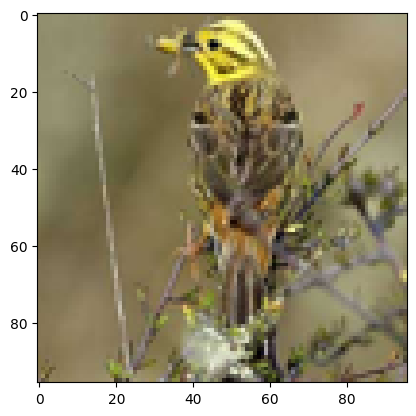

In [7]:
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from imageio import imsave
from tqdm import tqdm
import random
import shutil

HEIGHT = 96
WIDTH = 96
DEPTH = 3

SIZE = HEIGHT * WIDTH * DEPTH

DATA_DIR = './'
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

Data_path = '/kaggle/working/stl10_binary.tar.gz'
TRAIN_DATA_PATH = "/kaggle/working/stl10_binary/train_X.bin"
#TRAIN_DATA_PATH = '../input/stl10-binary-files/stl10_binary/train_X.bin'

TRAIN_LABEL_PATH = "/kaggle/working/stl10_binary/train_y.bin"
#TRAIN_LABEL_PATH = '../input/stl10-binary-files/stl10_binary/train_y.bin'

TEST_DATA_PATH = "/kaggle/working/stl10_binary/test_X.bin"
#TEST_DATA_PATH = '../input/stl10-binary-files/stl10_binary/test_X.bin'
TEST_LABEL_PATH = "/kaggle/working/stl10_binary/test_y.bin"
#TEST_LABEL_PATH = '../input/stl10-binary-files/stl10_binary/test_y.bin'

#UNLAB_DATA_PATH = '../input/stl10-binary-files/stl10_binary/unlabeled_X.bin'
def read_single_image(image_file):

  image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)

  image = np.reshape(image, (3, 96, 96))
  image = np.transpose(image, (2, 1, 0))
  return image

def plot_image(image):
  
  plt.imshow(image)
  plt.show()
with open(TRAIN_DATA_PATH) as f:
  image = read_single_image(f)
  plot_image(image)

def read_labels(path_to_labels):

    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_all_images(path_to_data):

    with open(path_to_data, 'rb') as f:
        everything = np.fromfile(f, dtype=np.uint8)

        images = np.reshape(everything, (-1, 3, 96, 96))
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def save_images(images, labels, types):
    i = 0
    for image in tqdm(images, position=0):
        label = labels[i] 
        directory = DATA_DIR + '/' + types + '/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        #print(filename)
        save_image(image, filename)
        i = i+1
        
def save_unlabelled_images(images):
    i = 0
    for image in tqdm(images, position=0):
        directory = DATA_DIR + '/' + 'unlabelled' + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        save_image(image, filename)
        i = i+1 
        

def create_val_dataset():
    train_image_path = DATA_DIR + "train"
    folders = os.listdir(train_image_path)

    for folder in tqdm(folders, position=0):
        temp_dir = DATA_DIR +"/train/" + folder
        temp_image_list = os.listdir(temp_dir)

    for i in range(50):
        val_dir = DATA_DIR + "/val/" + folder
        try:
            os.makedirs(val_dir, exist_ok=True)
        except OSError as exc:

            if exc.errno == errno.EEXIST:
                pass
        image_name = random.choice(temp_image_list)
        temp_image_list.remove(image_name)
        old_name = temp_dir + '/' + image_name
        new_name = val_dir + '/' + image_name
        os.replace(old_name, new_name)
        


In [8]:
train_labels = read_labels(TRAIN_LABEL_PATH)
train_images = read_all_images(TRAIN_DATA_PATH)

test_labels = read_labels(TEST_LABEL_PATH)
test_images = read_all_images(TEST_DATA_PATH)

#unlabelled_images = read_all_images(UNLAB_DATA_PATH)


In [9]:
save_images(train_images, train_labels, "train")
save_images(test_images, test_labels, "test")
#save_unlabelled_images(unlabelled_images)

100%|██████████| 8000/8000 [00:22<00:00, 353.10it/s]


In [14]:
import os
def load_imgs1(path,how_many):
    """
        returns images in range of 'how_many'
    """
    #path = '../input/pascal-voc-2007/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages/'
    #path ='/kaggle/input/stl10/train_images/'
    imgs_path = os.listdir(path)
    imgs = []
    
    for i,img in enumerate(imgs_path):
        if(i >= how_many):
            return imgs
        imgs.append(load_img(path+img))
    return imgs 

In [11]:
def to_np_array(images):
    new_images = []
    for image in images:
        new_images.append(np.array(image))
    return (np.array(new_images)/255.0)

In [12]:
def get_resized_images(images,size):
    """
        returns 3 np.arrays of the resized images
        the sizes are 72x72, 128x128, 288x288
    """
    imgs = []
    
    for img in images:
        img = img.resize((size,size))
        imgs.append(img)
        
    return to_np_array(imgs)

In [35]:
# loading only the first 100 pictures
train_path ='/kaggle/input/stl10/train_images/'
imgs = load_imgs1(train_path ,5000)
test_path ='/kaggle/input/stl10/test_images/'
imgs_test = load_imgs1(test_path ,1000)
# getting the images in 72X72, 144X144, 288X288 pixels

train_images1 = get_resized_images(imgs,128)
test_images1 = get_resized_images(imgs_test,128)
    
imgs_path = os.listdir(test_path)

In [36]:
#Test _image_list and labels
import pandas as pd
df = pd.DataFrame(columns=["test_image_name", "lables"])
test_image_folder = os.listdir("/kaggle/working/test")
i = 0
for folder in test_image_folder :
  #print(folder)
  new_path = "/kaggle/working/test" + os.sep + str(folder)
  folder_path = os.listdir(new_path)
  print(len(folder_path))
  for img_name in folder_path :
      #print(img_name,"___",folder)
      df.loc[i] = [img_name,folder]
      i =i+1
df["test_image_name"] = 'test_image_png_' + df["test_image_name"]

800
800
800
800
800
800
800
800
800
800


In [37]:
test_image_name_list = df["test_image_name"].tolist()
test_label_list = df["lables"].tolist()

In [38]:
test =0.15
# Split into training, validation set
test_image_name_list_rest,test_image_final, test_label_list_rest,test_label_final = train_test_split(test_image_name_list,test_label_list, test_size=test, random_state=42)

In [39]:
def data_extraction(path1,image_names,n,m):


    x_t =[]
    y_t1 =[]
    img_x = []
    img_y = []

    images = []


    for image_name in image_names:
      image_path = os.path.join(path1, image_name)
      if os.path.exists(image_path):
            #image = Image.open(image_path)
            image =(cv2.resize(cv2.imread(image_path),(n,m)))
            #time.sleep(0.001)
            images.append(image)


    # convert the images in to array
    # Normalize pixel values to be between 0 and 1
    x_t = np.array(images)/255
    



    return x_t 

In [40]:
  
test_images_stl10 = data_extraction(test_path,test_image_final,128,128)


In [41]:
test_label_final= [int(x) for x in test_label_final]
test_label_final = np.array(test_label_final)

# Preprocess images (resize, normalize, etc.)


In [42]:
# changhe the classification from 1-10 to 0-9 for train and test dataset
train_labels1 = train_labels - 1
test_labels1 = test_label_final - 1


In [43]:
# One-hot encode labels for train and test dataset
train_labels_cat = tf.keras.utils.to_categorical(train_labels1)
test_labels_cat = tf.keras.utils.to_categorical(test_labels1)

In [ ]:
path ='/kaggle/input/stl10/train_images/'

#Task 2: Feature Extraction

In [44]:
bottleneck= 256
ae=AutoEncoder(
    input_dim=(128,128,3),
    enc_filters=[32,16,8],
    enc_strides=[1,2,2],
    filter_size=[3,3,3,3],
    bottleneck = 256,
    dec_filters=[8,16,32,3],
    dec_strides=[2,2,1,1],
    batch_norm=True
    )

(None, 32, 32, 8)


In [33]:
ae.model.load_weights('/kaggle/working/weights1/weights.h5')
# Load the encoder part of the autoencoder
bottle_neck = ae.model.get_layer('encoder_output')
feature_model = Model(inputs=ae.model.input, outputs=bottle_neck.output)
feature_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv0 (Conv2D)      (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 encoder_conv1 (Conv2D)      (None, 64, 64, 16)        4624      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 16)        0         
                                                           

In [46]:
# Extract features from encoder
train_features = feature_model.predict(train_images1) #for 5000 sample 
test_features = feature_model.predict(test_images_stl10)# for 1000 sample

38/38 [==============================] - 0s 5ms/step


In [47]:
test =0.2
# Split into training, validation set
x_train_80,x_val_20, y_train_80,y_val_20 = train_test_split(train_features,train_labels_cat, test_size=test, random_state=42)

2. Use the encoder of the above-pretrained autoencoder (Refer to task 1.9) as a
feature extractor.

In [79]:
train_labels_cat[0:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [48]:
class MLP_3():

    def __init__(self,input_dim):

        #AE Initialization
        self.input_dim=input_dim
        
        self._build()

    def _build(self):


        #MLP_layer 3 Stack
        
        self.model_3_layers = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(256,),name = "L1"),
        tf.keras.layers.Dense(64, activation='relu',name = "L2"),
        tf.keras.layers.Dense(32, activation='relu',name = "L3"),
        tf.keras.layers.Dense(10, activation='softmax',name = "Output") ])

        
        
    def load_weights(self,path_name):
        self.model_3_layers.load_weights(path_name)
        #self.encoder.load_weights(path_name)

    

    
    def compile(self,initial_lr):
        self.initial_lr=initial_lr
        self.model_3_layers.compile(optimizer=Adam(learning_rate=self.initial_lr),loss='categorical_crossentropy',metrics=['accuracy'])

    

    def train(self,x_train,y_train,batch_size,shuffle,epochs,steps_per_epoch,callbacks_list,x_val,y_val):

        history = self.model_3_layers.fit(x=x_train,y=y_train,batch_size=batch_size,
                       shuffle=shuffle,epochs=epochs,steps_per_epoch =steps_per_epoch, callbacks=callbacks_list,validation_data=(x_val, y_val))
        return history






In [49]:
class MLP_5():

    def __init__(self,input_dim):

        #AE Initialization
        self.input_dim=input_dim
        

        self._build()

    def _build(self):


        #MLP_layer 3 Stack
        
        self.model_5_layers = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape= (256,) ,name = "L1"),
        tf.keras.layers.Dense(128, activation='relu',name = "L2"),
        tf.keras.layers.Dense(64, activation='relu',name = "L3"),
        tf.keras.layers.Dense(32, activation='relu',name = "L4"),
        tf.keras.layers.Dense(16, activation='relu',name = "L5"),
        tf.keras.layers.Dense(10, activation='softmax',name = "Output") ])

        
        
    def load_weights(self,path_name):
        self.model_5_layers.load_weights(path_name)
        #self.encoder.load_weights(path_name)

    

    
    def compile(self,initial_lr):
        self.initial_lr=initial_lr
        self.model_5_layers.compile(optimizer=Adam(learning_rate=self.initial_lr),loss='categorical_crossentropy',metrics=['accuracy'])

    

    def train(self,x_train,y_train,batch_size,shuffle,epochs,steps_per_epoch,callbacks_list,x_val,y_val):

        history = self.model_5_layers.fit(x=x_train,y=y_train,batch_size=batch_size,
                       shuffle=shuffle,epochs=epochs,steps_per_epoch =steps_per_epoch, callbacks=callbacks_list,validation_data=(x_val, y_val))
        return history

In [50]:
mlp3 = MLP_3(input_dim =(256,))
mlp5 = MLP_5(input_dim =(256,))

In [51]:
# MLP3 model

mlp3 = MLP_3 (input_dim =(256,))

# Compile the model
learning_rate = 0.001
mlp3.compile(0.001)
checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights_mlp3/weights.h5'), save_weights_only = True, verbose=1)
lr_schedule=LearningRateScheduler(step_decay)
callbacks_list=[lr_schedule,checkpoint]

print('#'*50)
print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
# Train the autoencoder  a. Use 80-10-10, train-val-test split
output_mlp3 = mlp3.train(x_train =x_train_80, y_train = y_train_80
, batch_size=16
, shuffle = True
, epochs = 30
, steps_per_epoch = 313                     
, callbacks_list=callbacks_list , x_val = x_val_20 , y_val = y_val_20 )

##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
294/313 [===========================>..] - ETA: 0s - loss: 2.7071 - accuracy: 0.1116
Epoch 1: saving model to /kaggle/working/weights_mlp3/weights.h5
313/313 [==============================] - 1s 4ms/step - loss: 2.6814 - accuracy: 0.1124 - val_loss: 2.3407 - val_accuracy: 0.0970 - lr: 0.0010
0.001 1
Epoch 2/30
312/313 [============================>.] - ETA: 0s - loss: 2.2685 - accuracy: 0.1328
Epoch 2: saving model to /kaggle/working/weights_mlp3/weights.h5
313/313 [==============================] - 1s 3ms/step - loss: 2.2687 - accuracy: 0.1324 - val_loss: 2.3591 - val_accuracy: 0.0920 - lr: 0.0010
0.001 2
Epoch 3/30
306/313 [============================>.] - ETA: 0s - loss: 2.2499 - accuracy: 0.1507
Epoch 3: saving model to /kaggle/working/weights_mlp3/weights.h5
313/313 [==============================] - 1s 3ms/step - loss: 2.2497 - accuracy: 0.1514 - 

3. Build a downstream task classifier (a MLP) with (100% training samples) and
choose the best one among a, and b for Task 2.4.

In [54]:
# MLP3 model

mlp5 = MLP_5 (input_dim =(256,))

# Compile the model
learning_rate = 0.001
mlp5.compile(0.001)
checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights_mlp5/weights.h5'), save_weights_only = True, verbose=1)
lr_schedule=LearningRateScheduler(step_decay)
callbacks_list=[lr_schedule,checkpoint]

print('#'*50)
print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
# Train the autoencoder  a. Use 80-10-10, train-val-test split
output_mlp5 = mlp5.train(x_train =x_train_80, y_train = y_train_80
, batch_size=16
, shuffle = True
, epochs = 30
, steps_per_epoch = 313                     
, callbacks_list=callbacks_list , x_val = x_val_20 , y_val = y_val_20 )

##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/30
303/313 [============================>.] - ETA: 0s - loss: 2.3738 - accuracy: 0.1104
Epoch 1: saving model to /kaggle/working/weights_mlp5/weights.h5
313/313 [==============================] - 2s 4ms/step - loss: 2.3722 - accuracy: 0.1106 - val_loss: 2.3112 - val_accuracy: 0.1080 - lr: 0.0010
0.001 1
Epoch 2/30
311/313 [============================>.] - ETA: 0s - loss: 2.3022 - accuracy: 0.1148
Epoch 2: saving model to /kaggle/working/weights_mlp5/weights.h5
313/313 [==============================] - 1s 4ms/step - loss: 2.3022 - accuracy: 0.1148 - val_loss: 2.3312 - val_accuracy: 0.0930 - lr: 0.0010
0.001 2
Epoch 3/30
313/313 [==============================] - ETA: 0s - loss: 2.3022 - accuracy: 0.1134
Epoch 3: saving model to /kaggle/working/weights_mlp5/weights.h5
313/313 [==============================] - 1s 3ms/step - loss: 2.3022 - accuracy: 0.1134 - 

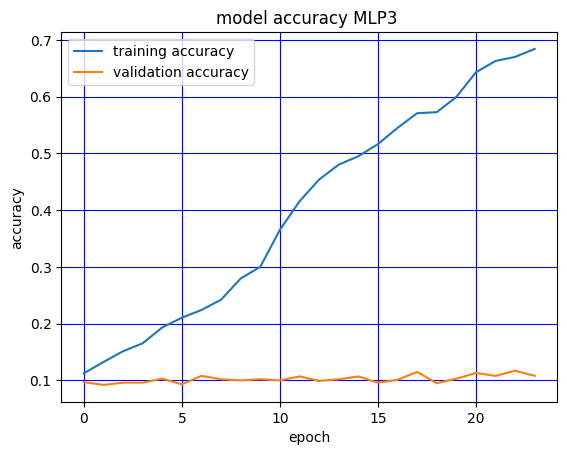

In [95]:
from matplotlib import pyplot as plt
plt.plot(output_mlp3.history['accuracy'])
plt.plot(output_mlp3.history['val_accuracy'])
plt.title('model accuracy MLP3 ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
plt.grid(which='major', color='b', linestyle='-')
plt.show()

a. # hidden_layer = 3
b. # hidden_layer = 5

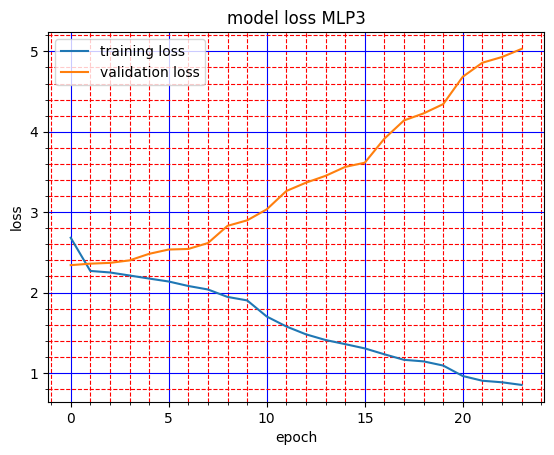

In [96]:
plt.plot(output_mlp3.history['loss'])
plt.plot(output_mlp3.history['val_loss'])
plt.title('model loss MLP3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.grid(which='minor', color='r', linestyle='--')
plt.minorticks_on()
plt.grid(which='major', color='b', linestyle='-')
plt.show()

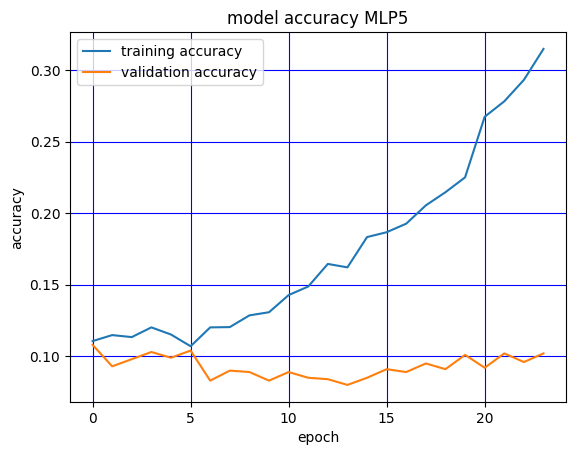

In [97]:
from matplotlib import pyplot as plt
plt.plot(output_mlp5.history['accuracy'])
plt.plot(output_mlp5.history['val_accuracy'])
plt.title('model accuracy MLP5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
plt.grid(which='major', color='b', linestyle='-')
plt.show()

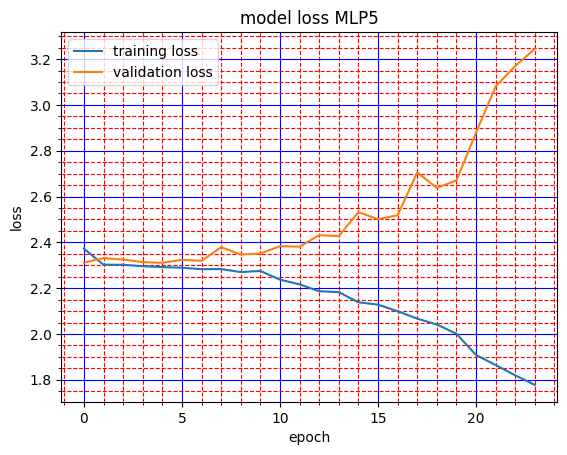

In [98]:
plt.plot(output_mlp5.history['loss'])
plt.plot(output_mlp5.history['val_loss'])
plt.title('model loss MLP5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.grid(which='minor', color='r', linestyle='--')
plt.minorticks_on()
plt.grid(which='major', color='b', linestyle='-')
plt.show()

4. Use the best from Task 2.3.a and 2.3.b, fine-tune the classifier on the STL-10
dataset with the following % of training samples

In [92]:
# Sample code for generating predictions, computing confusion matrix, and AUC-ROC curve

# Assuming you have a trained model (either from Task 3 or Task 4)
predictions_mlp3 = mlp3.model_3_layers.predict(test_features)
y_true = tf.argmax(test_labels_cat, axis=1)
y_pred = tf.argmax(predictions_mlp3, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
print(confusion_matrix)
# Code for AUC-ROC curve using scikit-learn
#from sklearn.metrics import roc_auc_score
#auc = roc_auc_score(y_true, y_pred)
#print("MLP3 AUC value is ::",auc)
# Print or visualize the confusion matrix and AUC-ROC curve

38/38 [==============================] - 0s 2ms/step
tf.Tensor(
[[10  8 10 13 12  8  8 11 15 29]
 [19 12 14 10  9  6  5 14  8 19]
 [18  9 12 13 11 10  8 15 13 25]
 [12 17  9  8 11  8 10 10 11 17]
 [ 5 12 11  8  7 14  8 11 14 15]
 [19  8  5  5 11  6  9 14 13 20]
 [18  7 12  9 18  5  8 13 13 23]
 [17  4  7  8 10  8 18 15 17 18]
 [11  9  9 15 15  9  9  8 16 19]
 [12  5 17 15  7 15  8 12 15 24]], shape=(10, 10), dtype=int32)


ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
tf.argmax(predictions, axis=1).shape

Confusion matrix for MLP3:
[[10  8 10 13 12  8  8 11 15 29]
 [19 12 14 10  9  6  5 14  8 19]
 [18  9 12 13 11 10  8 15 13 25]
 [12 17  9  8 11  8 10 10 11 17]
 [ 5 12 11  8  7 14  8 11 14 15]
 [19  8  5  5 11  6  9 14 13 20]
 [18  7 12  9 18  5  8 13 13 23]
 [17  4  7  8 10  8 18 15 17 18]
 [11  9  9 15 15  9  9  8 16 19]
 [12  5 17 15  7 15  8 12 15 24]]
Classification report rebuilt from confusion matrix {mlp3}:
              precision    recall  f1-score   support

           0       0.07      0.08      0.08       124
           1       0.13      0.10      0.12       116
           2       0.11      0.09      0.10       134
           3       0.08      0.07      0.07       113
           4       0.06      0.07      0.06       105
           5       0.07      0.05      0.06       110
           6       0.09      0.06      0.07       126
           7       0.12      0.12      0.12       122
           8       0.12      0.13      0.13       120
           9       0.11      0.18      0.

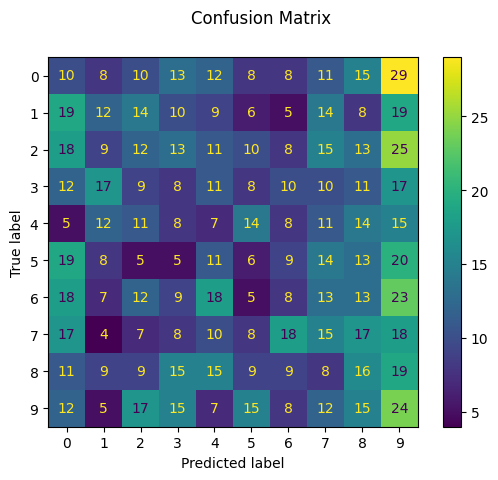

In [81]:
from sklearn import svm, datasets, metrics 
'''print(
    f"Classification report for classifier {mlp3}:\n"
    f"{metrics.classification_report(tf.argmax(test_labels_cat, axis=1), tf.argmax(predictions, axis=1))}\n"
    )'''
#accuracy_test = accuracy_score(predicted, y_test)
#print("Accuracy_test  : ", round(accuracy_test,3))
disp = metrics.ConfusionMatrixDisplay.from_predictions(tf.argmax(test_labels_cat, axis=1), tf.argmax(predictions_mlp3, axis=1))
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix for MLP3:\n{disp.confusion_matrix}")


# The ground truth and predicted lists
y_true = []
y_pred = []
cm = disp.confusion_matrix

# For each cell in the confusion matrix, add the corresponding ground truths
# and predictions to the lists
for gt in range(len(cm)):
    for pred in range(len(cm)):
        y_true += [gt] * cm[gt][pred]
        y_pred += [pred] * cm[gt][pred]

print(
    "Classification report rebuilt from confusion matrix {mlp3}:\n"
    f"{metrics.classification_report(y_true, y_pred)}\n"
)

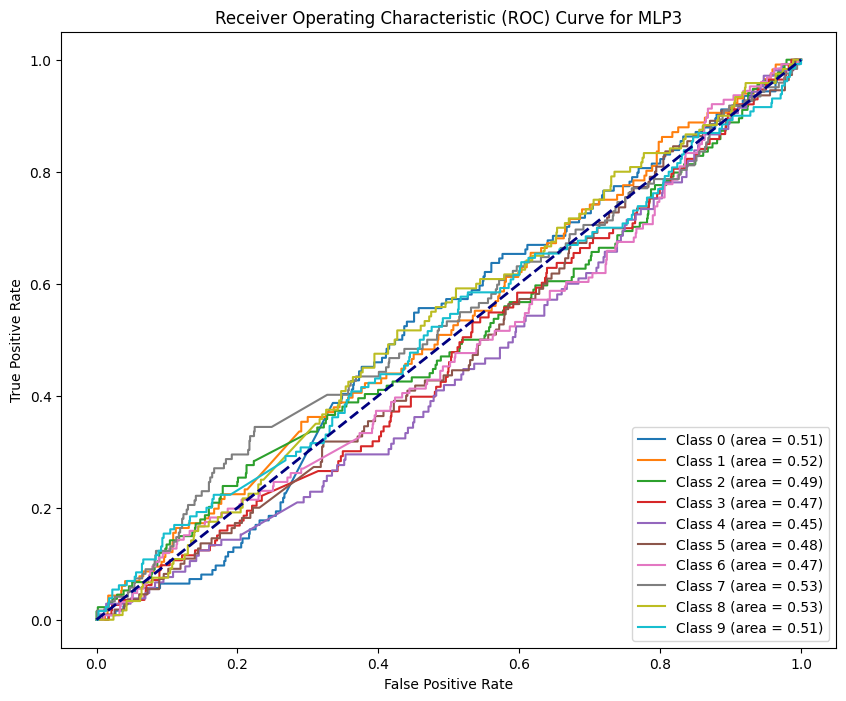

In [80]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
# Compute ROC curve and ROC area for each class

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # Assuming num_classes is the total number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
 
num_classes = 10
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], predictions_mlp3[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for MLP3')
plt.legend(loc="lower right")
plt.show()

In [76]:
# Sample code for generating predictions, computing confusion matrix, and AUC-ROC curve

# Assuming you have a trained model (either from Task 3 or Task 4)
predictions_mlp5 = mlp5.model_5_layers.predict(test_features)
y_true = tf.argmax(test_labels_cat, axis=1)
y_pred = tf.argmax(predictions_mlp5, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
print(confusion_matrix)

38/38 [==============================] - 0s 2ms/step
tf.Tensor(
[[ 6 12  0 11 13  3 60  6  5  8]
 [ 4 11  8 23 10  2 41  6  3  8]
 [ 6 11  2 24 13  2 55 10  5  6]
 [ 3  5  4 18 13  1 48  9 10  2]
 [ 2  7  4 16 11  0 45  9  9  2]
 [ 9 10  3 21 10  0 41  4  7  5]
 [ 6  8  9 17 12  5 38 17  7  7]
 [ 7 12  5 22 11  1 38 15  6  5]
 [ 6 13  2 14  8  3 52  8  8  6]
 [ 5 18  2 21 10  4 53  8  7  2]], shape=(10, 10), dtype=int32)


Confusion matrix for MLP5:
[[ 6 12  0 11 13  3 60  6  5  8]
 [ 4 11  8 23 10  2 41  6  3  8]
 [ 6 11  2 24 13  2 55 10  5  6]
 [ 3  5  4 18 13  1 48  9 10  2]
 [ 2  7  4 16 11  0 45  9  9  2]
 [ 9 10  3 21 10  0 41  4  7  5]
 [ 6  8  9 17 12  5 38 17  7  7]
 [ 7 12  5 22 11  1 38 15  6  5]
 [ 6 13  2 14  8  3 52  8  8  6]
 [ 5 18  2 21 10  4 53  8  7  2]]
Classification report rebuilt from confusion matrix {mlp5}:
              precision    recall  f1-score   support

           0       0.11      0.05      0.07       124
           1       0.10      0.09      0.10       116
           2       0.05      0.01      0.02       134
           3       0.10      0.16      0.12       113
           4       0.10      0.10      0.10       105
           5       0.00      0.00      0.00       110
           6       0.08      0.30      0.13       126
           7       0.16      0.12      0.14       122
           8       0.12      0.07      0.09       120
           9       0.04      0.02      0.

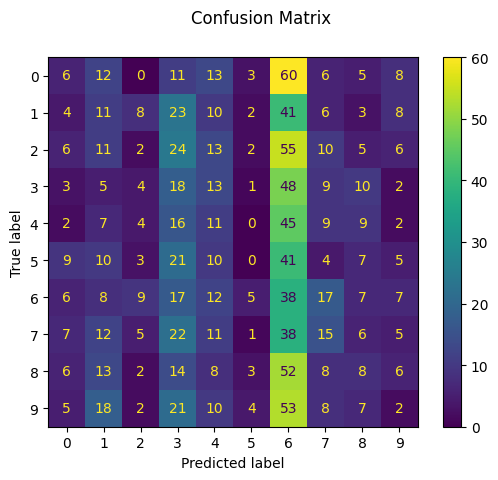

In [82]:
from sklearn import svm, datasets, metrics 
'''print(
    f"Classification report for classifier {mlp5}:\n"
    f"{metrics.classification_report(tf.argmax(test_labels_cat, axis=1), tf.argmax(predictions, axis=1))}\n"
    )'''
#accuracy_test = accuracy_score(predicted, y_test)
#print("Accuracy_test  : ", round(accuracy_test,3))
disp = metrics.ConfusionMatrixDisplay.from_predictions(tf.argmax(test_labels_cat, axis=1), tf.argmax(predictions_mlp5, axis=1))
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix for MLP5:\n{disp.confusion_matrix}")


# The ground truth and predicted lists
y_true = []
y_pred = []
cm = disp.confusion_matrix

# For each cell in the confusion matrix, add the corresponding ground truths
# and predictions to the lists
for gt in range(len(cm)):
    for pred in range(len(cm)):
        y_true += [gt] * cm[gt][pred]
        y_pred += [pred] * cm[gt][pred]

print(
    "Classification report rebuilt from confusion matrix {mlp5}:\n"
    f"{metrics.classification_report(y_true, y_pred)}\n"
)

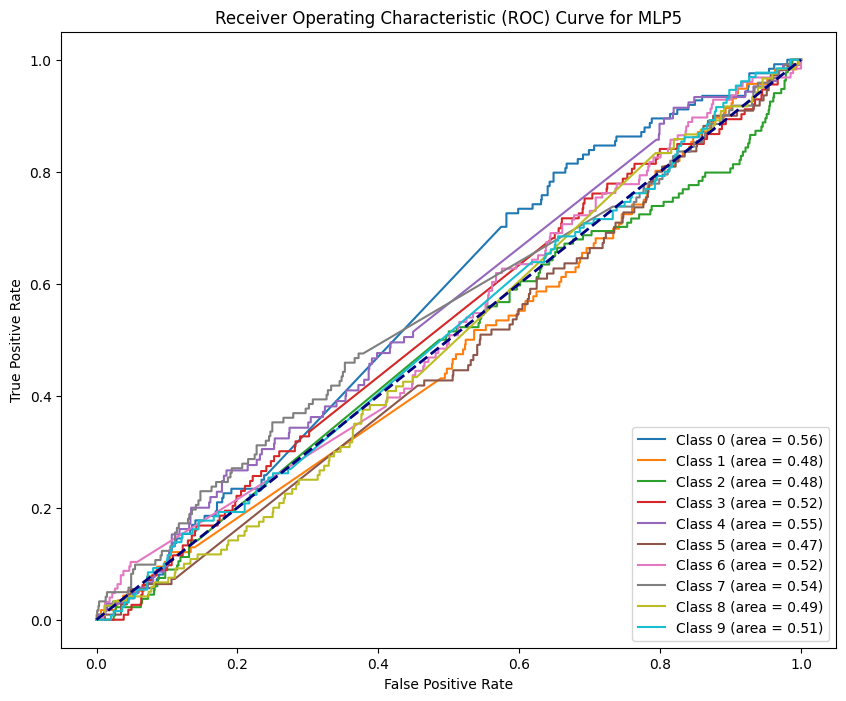

In [83]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
# Compute ROC curve and ROC area for each class

# Binarize the labels
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # Assuming num_classes is the total number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()
 
num_classes = 10
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], predictions_mlp5[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for MLP5')
plt.legend(loc="lower right")
plt.show()

4. Use the best from Task 2.3.a and 2.3.b, fine-tune the classifier on the STL-10
dataset with the following % of training samples 
a. 1%
b. 10%
c. 20%
d. 40%.
e. 60 %

In [ ]:
bottleneck_list = [128,64,32,16]

i = 0

ae_list = [str("conv_enc")+ str(i) for i in bottleneck_list ] 
output_list = [str("output_conv_enc")+ str(i) for i in bottleneck_list ]

In [85]:
train_sample_percentage = [0.1,0.2,0.4,0.6]
output_mlp3_list = [str("output_mlp3_")+ str(i) for i in train_sample_percentage ]
print(output_mlp3_list)

['output_mlp3_0.1', 'output_mlp3_0.2', 'output_mlp3_0.4', 'output_mlp3_0.6']


In [87]:
n = 5000  
batch = 50 
steps_per_epoch = n // 50 


100


####################################################################################################
For Train sample : 0.01
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/15
1/3 [=========>....................] - ETA: 0s - loss: 7.2030 - accuracy: 0.1250
Epoch 1: saving model to /kaggle/working/weights_mlp3_0.01/weights.h5
3/3 [==============================] - 1s 405ms/step - loss: 6.1938 - accuracy: 0.1042 - val_loss: 5.0600 - val_accuracy: 0.0982 - lr: 0.0010
0.001 1
Epoch 2/15
1/3 [=========>....................] - ETA: 0s - loss: 4.6780 - accuracy: 0.0000e+00
Epoch 2: saving model to /kaggle/working/weights_mlp3_0.01/weights.h5
3/3 [==============================] - 1s 313ms/step - loss: 2.8306 - accuracy: 0.2353 - val_loss: 4.6716 - val_accuracy: 0.1008 - lr: 0.0010
0.001 2
Epoch 3/15
1/3 [=========>....................] - ETA: 0s - loss: 2.0079 - accuracy: 0.3750
Epoch 3: saving model to /kaggle/

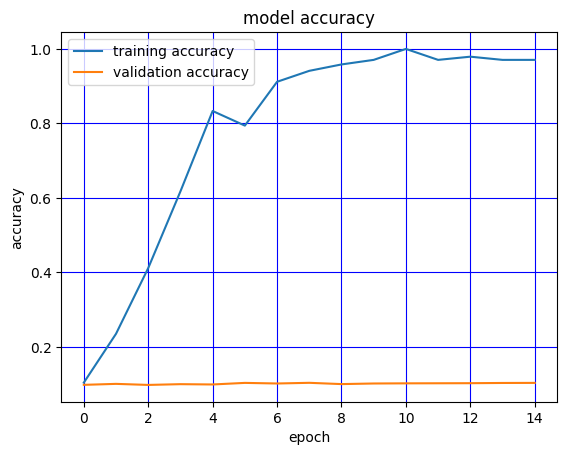

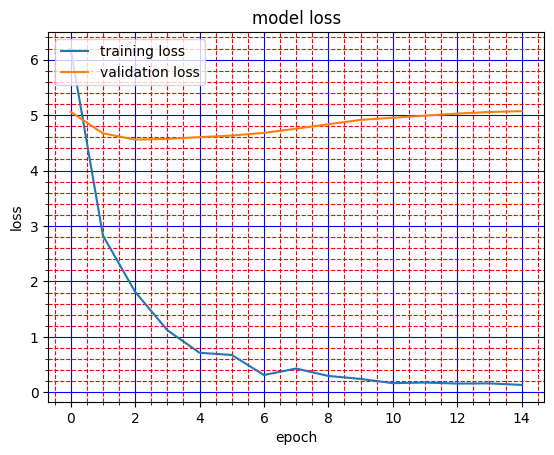

####################################################################################################
For Train sample : 0.1
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/15
18/31 [================>.............] - ETA: 0s - loss: 5.5444 - accuracy: 0.1042  
Epoch 1: saving model to /kaggle/working/weights_mlp3_0.1/weights.h5
31/31 [==============================] - 1s 27ms/step - loss: 4.7162 - accuracy: 0.1129 - val_loss: 3.5841 - val_accuracy: 0.1029 - lr: 0.0010
0.001 1
Epoch 2/15
19/31 [=================>............] - ETA: 0s - loss: 2.3029 - accuracy: 0.2397    
Epoch 2: saving model to /kaggle/working/weights_mlp3_0.1/weights.h5
31/31 [==============================] - 1s 25ms/step - loss: 2.3029 - accuracy: 0.2459 - val_loss: 3.2347 - val_accuracy: 0.1020 - lr: 0.0010
0.001 2
Epoch 3/15
17/31 [===============>..............] - ETA: 0s - loss: 1.7557 - accuracy: 0.4077
Epoch 3: saving model to /

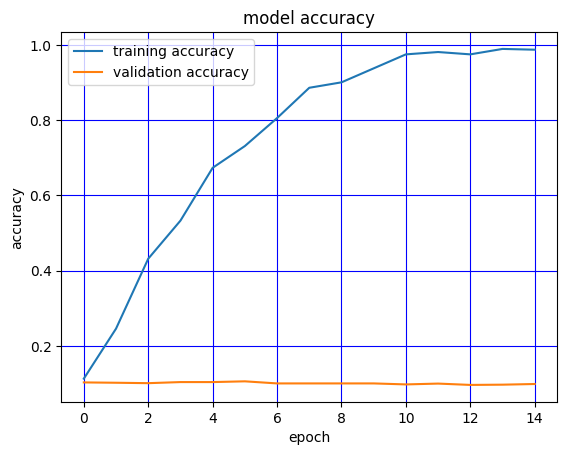

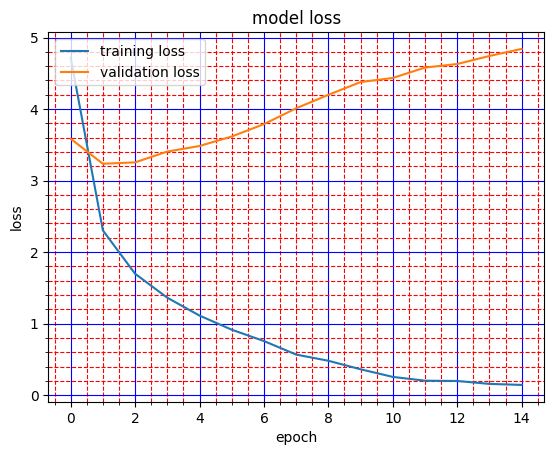

####################################################################################################
For Train sample : 0.2
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/15
56/62 [==========================>...] - ETA: 0s - loss: 4.0475 - accuracy: 0.1004
Epoch 1: saving model to /kaggle/working/weights_mlp3_0.2/weights.h5
62/62 [==============================] - 2s 17ms/step - loss: 3.9057 - accuracy: 0.1028 - val_loss: 2.7516 - val_accuracy: 0.0930 - lr: 0.0010
0.001 1
Epoch 2/15
54/62 [=========================>....] - ETA: 0s - loss: 2.2236 - accuracy: 0.1869
Epoch 2: saving model to /kaggle/working/weights_mlp3_0.2/weights.h5
62/62 [==============================] - 1s 14ms/step - loss: 2.2306 - accuracy: 0.1829 - val_loss: 2.5932 - val_accuracy: 0.0940 - lr: 0.0010
0.001 2
Epoch 3/15
53/62 [========================>.....] - ETA: 0s - loss: 1.9959 - accuracy: 0.2726
Epoch 3: saving model to /kaggle

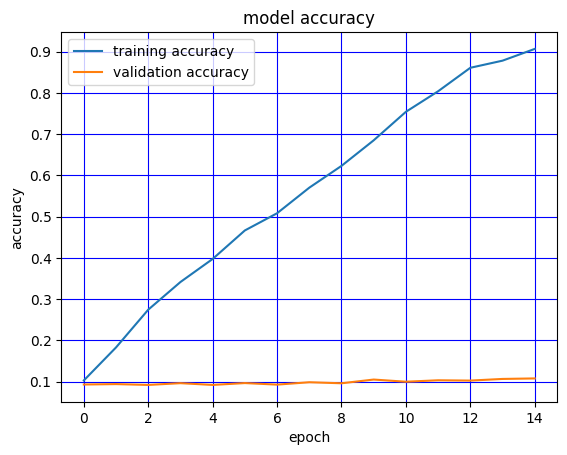

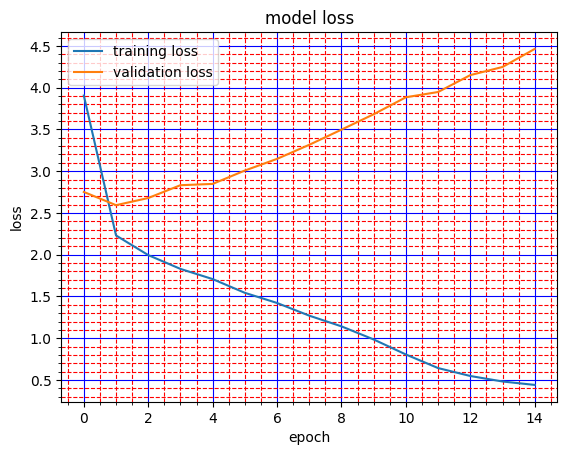

####################################################################################################
For Train sample : 0.4
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/15
117/125 [===========================>..] - ETA: 0s - loss: 3.4022 - accuracy: 0.0983
Epoch 1: saving model to /kaggle/working/weights_mlp3_0.4/weights.h5
125/125 [==============================] - 1s 7ms/step - loss: 3.3452 - accuracy: 0.0975 - val_loss: 2.5149 - val_accuracy: 0.0943 - lr: 0.0010
0.001 1
Epoch 2/15
119/125 [===========================>..] - ETA: 0s - loss: 2.2611 - accuracy: 0.1717
Epoch 2: saving model to /kaggle/working/weights_mlp3_0.4/weights.h5
125/125 [==============================] - 1s 8ms/step - loss: 2.2645 - accuracy: 0.1710 - val_loss: 2.4777 - val_accuracy: 0.0940 - lr: 0.0010
0.001 2
Epoch 3/15
119/125 [===========================>..] - ETA: 0s - loss: 2.1616 - accuracy: 0.2069
Epoch 3: saving model to

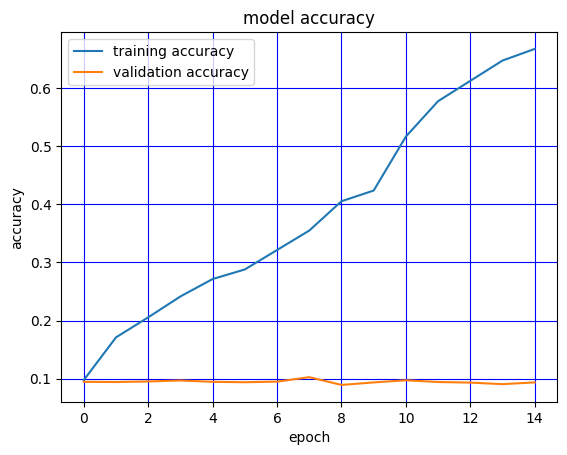

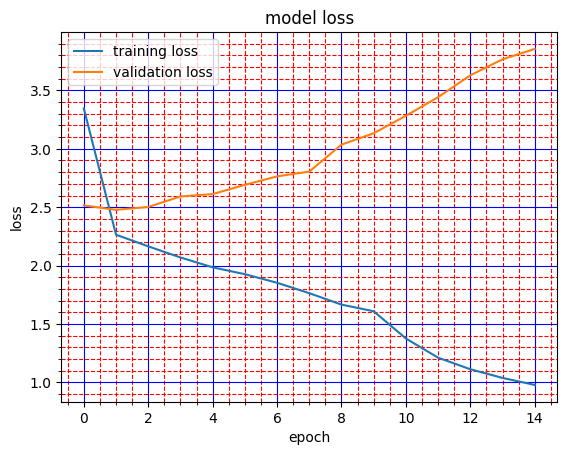

####################################################################################################
For Train sample : 0.6
##################################################
# Train the autoencoder  a. Use 80-10-10, train-val-test split
0.001 0
Epoch 1/15
187/187 [==============================] - ETA: 0s - loss: 2.6141 - accuracy: 0.0983
Epoch 1: saving model to /kaggle/working/weights_mlp3_0.6/weights.h5
187/187 [==============================] - 1s 5ms/step - loss: 2.6141 - accuracy: 0.0983 - val_loss: 2.3139 - val_accuracy: 0.0930 - lr: 0.0010
0.001 1
Epoch 2/15
180/187 [===========================>..] - ETA: 0s - loss: 2.2910 - accuracy: 0.1194
Epoch 2: saving model to /kaggle/working/weights_mlp3_0.6/weights.h5
187/187 [==============================] - 1s 4ms/step - loss: 2.2925 - accuracy: 0.1183 - val_loss: 2.3325 - val_accuracy: 0.0915 - lr: 0.0010
0.001 2
Epoch 3/15
176/187 [===========================>..] - ETA: 0s - loss: 2.2746 - accuracy: 0.1275
Epoch 3: saving model to

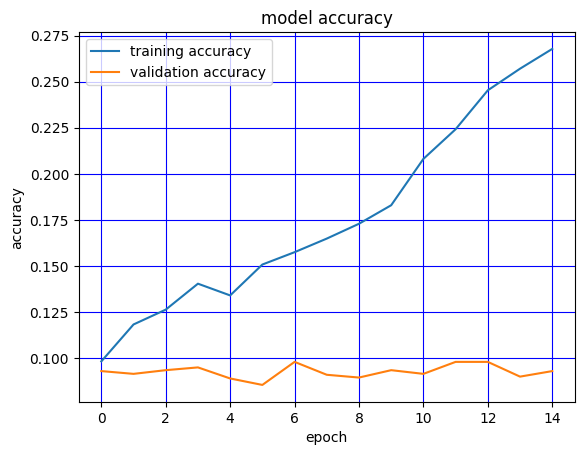

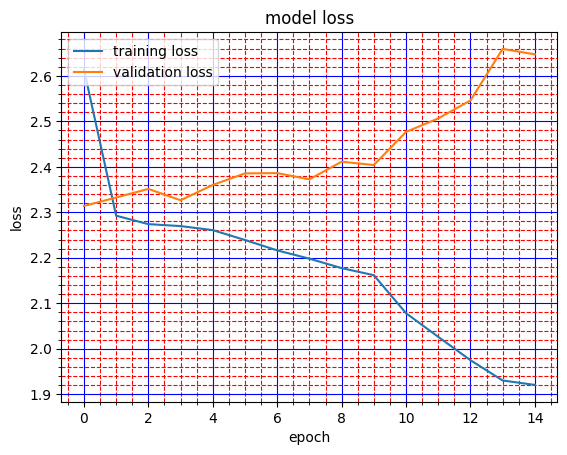

In [99]:
# Sample code for fine-tuning the classifier with different percentages of training samples
 
 
train_sample_percentage = [0.01,0.1,0.2,0.4,0.6]
output_mlp3_list = [str("output_mlp3_")+ str(i) for i in train_sample_percentage ]
i = 0
# Assuming you have functions to split data into different percentages
for train in train_sample_percentage :
# Split into training, validation set
    x_train,x_val, y_train,y_val = train_test_split(train_features,train_labels_cat, test_size=1-train, random_state=42)
    print("##"*50)
    print("For Train sample :" , train )
    
    sample = 5000*train
    batch = 16 
    steps_per_epoch = sample // 16
    
    # MLP3 model

    mlp3 = MLP_3 (input_dim =(256,))

    # Compile the model
    learning_rate = 0.001
    mlp3.compile(0.001)
    checkpoint= ModelCheckpoint(os.path.join(os.getcwd(), 'weights_mlp3'+"_"+ str(train)+'/weights.h5'), save_weights_only = True, verbose=1)
    lr_schedule=LearningRateScheduler(step_decay)
    callbacks_list=[lr_schedule,checkpoint]

    print('#'*50)
    print("# Train the autoencoder  a. Use 80-10-10, train-val-test split")
    # Train the autoencoder  a. Use 80-10-10, train-val-test split
    output_mlp3_list[i] = mlp3.train(x_train =x_train, y_train = y_train
    , batch_size=16
    , shuffle = True
    , epochs = 15
    , steps_per_epoch = steps_per_epoch                     
    , callbacks_list=callbacks_list , x_val = x_val , y_val = y_val )
      
    print("Plot for model :::" ,output_mlp3_list[i])
    from matplotlib import pyplot as plt
    plt.plot(output_mlp3_list[i].history['accuracy'])
    plt.plot(output_mlp3_list[i].history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
    plt.grid(which='major', color='b', linestyle='-')
    plt.show()
    
    plt.plot(output_mlp3_list[i].history['loss'])
    plt.plot(output_mlp3_list[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    plt.grid(which='minor', color='r', linestyle='--')
    plt.minorticks_on()
    plt.grid(which='major', color='b', linestyle='-')
    plt.show()
    
        
    i = + 1
    

import tensorflow_datasets as tfds

# Load the STL10 dataset
stl10_builder = tfds.builder('stl10')

# Download the STL10 dataset
stl10_builder.download_and_prepare()

# Load the train and test datasets
train_dataset = stl10_builder.as_dataset(split='train')
test_dataset = stl10_builder.as_dataset(split='test')
